# Adversarial Attack Experiments on HPSV2

## Introduction
We seek to test the efficacy and transferability of white-box perturbation attacks against image quality classifier models to examine the impact on generated image quality

## Setup


In [166]:
import os
import hpsv2

from datasets import load_dataset
import torch
import clip
from PIL import Image
import torchattacks
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
import torch.nn as nn
import matplotlib.pyplot as plt





## Loading the image dataset


In [5]:
dataset = load_dataset("ymhao/HPDv2", cache_dir="cache")


Generating train split: 645090 examples [06:52, 1562.59 examples/s]
Generating test split: 400 examples [00:01, 370.48 examples/s]


In [4]:
dataset=load_dataset('/Users/harry/yuant/cache/downloads/extracted')

Computing checksums: 100%|██████████| 430060/430060 [00:33<00:00, 12795.53it/s]
Generating train split: 430060 examples [00:05, 81969.92 examples/s]
Generating test split: 3700 examples [00:00, 49224.24 examples/s]


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'image_path', 'raw_annotations', 'user_hash', 'image', 'rank', 'human_preference'],
        num_rows: 645090
    })
    test: Dataset({
        features: ['prompt', 'image_path', 'raw_annotations', 'user_hash', 'image', 'rank', 'human_preference'],
        num_rows: 400
    })
})

In [27]:
dataset['train'][64] # how each element of the dataset is structured
# dataset['train'][64]['image'][0]


{'prompt': 'A fisheye lens photograph of a residential bathroom',
 'image_path': "['00000040.jpg', '00000042.jpg']",
 'raw_annotations': [],
 'user_hash': [],
 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=426x640>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>],
 'rank': [],
 'human_preference': [1, 0]}

### Example usage of the HPSV2 model

In [15]:
result = (hpsv2.score(dataset['train'][64]['image'], 'A fisheye lens photograph of a residential bathroom', hps_version="v2.1"))
print(result)

[np.float32(0.23125021), np.float32(0.2759679)]


### Loading model for white-box adversarial attack

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
params = torch.load("/Users/harry/yuant/hpc.pt", map_location=torch.device(device))['state_dict']
model.load_state_dict(params)
# Example usage:
# image1 = preprocess(Image.open("image1.png")).unsqueeze(0).to(device)
# image2 = preprocess(Image.open("image2.png")).unsqueeze(0).to(device)
# images = torch.cat([image1, image2], dim=0)
# text = clip.tokenize(["your prompt here"]).to(device)

# with torch.no_grad():
#     image_features = model.encode_image(images)
#     text_features = model.encode_text(text)

#     image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#     text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#     hps = image_features @ text_features.T

/var/folders/h6/c_vfhl_j5gb1rk5pf_n90rz00000gn/T/ipykernel_61652/503983985.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load("/Users/harry/yuant/hpc.pt

<All keys matched successfully>

#### Example usage of torchattacks library using a non-attack

In [19]:
attack = torchattacks.VANILA(model)
image = dataset['train'][64]['image'][0]
image1 = preprocess(image).unsqueeze(0).to(device)
adv_images = attack(image1, 'A fisheye lens photograph of a residential bathroom')

Processing the image back to original input for model scoring

In [113]:
def unnormalize(tensor):

    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=tensor.device).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=tensor.device).view(3, 1, 1)
    tensor = tensor * std + mean  # Reverse the normalization
    return tensor


def tensor_to_pil(tensor):
    """Convert a tensor to a PIL Image."""
    tensor = tensor.clamp(0, 1)  # Clamp to ensure values are between 0 and 1
    return to_pil_image(tensor)

# Reverse normalization for each image
adv_images = torch.stack([unnormalize(img) for img in adv_images])

# Convert each tensor to a PIL image
adv_pil_images = [tensor_to_pil(img) for img in adv_images]

In [22]:
hpsv2.score(adv_pil_images[0] , 'A fisheye lens photograph of a residential bathroom', hps_version="v2.1") 

[np.float32(0.24432291)]

As you can see, we are left with the same HPSV score after preprocessing and unprocessing the image

## Modifying FGSM for CLIP Model

### 1. **Dual Inputs Handling**
- **Prepare Inputs**: Preprocess images and tokenize text to suit CLIP’s input requirements.
- **Device Assignment**: Ensure inputs are on the same device as the model.

### 2. **Custom Attack Function**
- **Setup**: Create a function for the FGSM attack tailored to handle image and text inputs.
- **Forward Pass**:
  - Execute model forward pass using both inputs.
  - Extract only the necessary output (logits) for loss calculation.

### 3. **Loss and Gradient Calculation**
- **Loss Calculation**:
  - Compute loss using a suitable function, ensuring to target the correct output component.
- **Backpropagation**:
  - Calculate gradients w.r.t. the image inputs.

### 4. **FGSM Perturbation**
- **Sign of Gradient**:
  - Determine the sign of the image gradients.
- **Perturbation**:
  - Apply the calculated sign multiplied by epsilon to the original images.
- **Clipping**:
  - Clip values to maintain valid image data.



In [103]:
def fgsm_clip_attack(model, images, texts, labels, eps, device):
    images = images.clone().detach().to(device).requires_grad_(True)
    texts = texts.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    n = labels.max()
    labels = labels / n
    # Forward pass
    outputs = model(images, texts)
    if isinstance(outputs, tuple):
        outputs = outputs[0]
    outputs = outputs.squeeze()
    outputs = torch.sigmoid(outputs)

    # Calculate loss using MSELoss or BCEWithLogitsLoss
    loss_fn = nn.MSELoss()
    if isinstance(outputs, tuple):  # Check if the outputs include more than logits
        outputs = outputs[0]  # Assuming the first element is the logits

    # Calculate loss
    loss = loss_fn(outputs, labels)
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Generate adversarial images
    with torch.no_grad():
        adv_images = images + eps * images.grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1)  # Ensure pixel values are valid
    
    return adv_images

In [104]:
def cw_clip_attack(model, images, texts, labels, c, device):
    # Ensure inputs are on the correct device and set up for gradient tracking
    images = images.clone().detach().to(device).requires_grad_(True)
    texts = texts.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    # Initialize parameters for the attack
    step_size = 0.01  # Learning rate for the optimizer
    max_iterations = 5  # Maximum number of iterations
    confidence = 10  # Confidence in pushing the adversarial example into the target class

    # Define optimizer for the adversarial example
    optimizer = torch.optim.Adam([images], lr=step_size)

    for i in range(max_iterations):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, texts)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Assuming the first element is the logits

        # Calculate the CW loss function
        real = torch.max(outputs * (1 - labels), 1)[0]
        other = torch.max(outputs * labels - 10000 * torch.eye(*outputs.shape, device=device), 1)[0]
        cw_loss = torch.sum(torch.clamp(real - other + confidence, min=0))  # Maximize the margin

        # Total loss
        loss = cw_loss + c * torch.sum(torch.pow(images - images.data, 2))

        # Backward pass
        loss.backward()
        optimizer.step()

        # Clamp the adversarial images to ensure they are valid images
        images.data = torch.clamp(images, min=0, max=1)

    return images.detach()

In [110]:
def PGD_clip_attack(model, images, texts, labels, eps, alpha, steps, device):
    images = images.clone().detach().to(device)
    texts = texts.clone().detach().to(device)
    labels = labels.clone().detach().to(device).float()

    # Initialize the adversarial images
    adv_images = images.clone().detach()

    # Add a small random perturbation to the images (optional)
    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-eps, eps)
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for i in range(steps):
        adv_images.requires_grad = True

        # Forward pass
        outputs = model(adv_images, texts)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        outputs = outputs.squeeze()
        outputs = torch.sigmoid(outputs)

        # Calculate loss
        loss_fn = nn.MSELoss()
        loss = loss_fn(outputs, labels)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Update adversarial images
        grad = adv_images.grad.data
        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

    return adv_images

### Now we will run our experiment using different torch attacks. 
We decide to focus our experiment on the leading adversarial image perturbations: FGSM, PGD, CW, We also use GN as a benchmark.

In [106]:
dataset['train'][0]

{'prompt': 'A valley filled with red flowers with smoke flowing around - digital art by Studio Ghibli.',
 'image_path': "['00000000.jpg', '00000001.jpg']",
 'raw_annotations': [],
 'user_hash': [],
 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x480>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>],
 'rank': [],
 'human_preference': [0, 1]}

In [107]:
for i in range((3)):
    print(dataset['train'][i])   
    images = [preprocess(img).unsqueeze(0).to(device) for img in row['image']]
    text_prompt = row['prompt']
    text_input = clip.tokenize([text_prompt]).to(device)


{'prompt': 'A valley filled with red flowers with smoke flowing around - digital art by Studio Ghibli.', 'image_path': "['00000000.jpg', '00000001.jpg']", 'raw_annotations': [], 'user_hash': [], 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x480 at 0x13F7DA000>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x13F7E5760>], 'rank': [], 'human_preference': [0, 1]}
{'prompt': 'A valley filled with red flowers with smoke flowing around - digital art by Studio Ghibli.', 'image_path': "['00000001.jpg', '00000002.jpg']", 'raw_annotations': [], 'user_hash': [], 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x13F7E73E0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x13F7E7500>], 'rank': [], 'human_preference': [0, 1]}
{'prompt': 'A valley filled with red flowers with smoke flowing around - digital art by Studio Ghibli.', 'image_path': "['00000000.jpg', '00000003.jpg']", 'raw_annotations': [], 'user_hash

In [ ]:
# for hps_version = 1.0

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
params = torch.load("/Users/harry/yuant/hpc.pt", map_location=torch.device(device))['state_dict']
model.load_state_dict(params)

/var/folders/h6/c_vfhl_j5gb1rk5pf_n90rz00000gn/T/ipykernel_61652/1051977988.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load("/Users/harry/yuant/hpc.p

<All keys matched successfully>

In [ ]:
def evaluate_all_images(images_tensor, prompt, adv_images_dict, model):
    """
    Evaluates original and adversarial images using the HPS model.

    Args:
        images_tensor (torch.Tensor): Tensor of original images.
        prompt (str): Text prompt for evaluation.
        adv_images_dict (dict): Dictionary of adversarial images.
        model (torch.nn.Module): Loaded HPS model.

    Returns:
        scores_dict (dict): Scores for each attack type and original images.
        pil_images_dict (dict): PIL representations of images for each type.
    """
    # Evaluate original images
    #prompt = clip.tokenize([prompt]).to(adv_images[0].device)
    prompt = clip.tokenize([prompt]).to(device)

    original_scores, original_pil_images = evaluate_original_images(images_tensor, prompt, model)
    
    scores_dict = {'original': original_scores}
    pil_images_dict = {'original': original_pil_images}
    # Evaluate adversarial images for each attack type
    for attack_name, adv_images in adv_images_dict.items():
        adv_scores, adv_pil_images = process_and_evaluate_adversarial_images(
            adv_images, attack_name, prompt, model, original_scores=original_scores
        )
        scores_dict[attack_name] = adv_scores
        pil_images_dict[attack_name] = adv_pil_images

    return scores_dict, pil_images_dict


def evaluate_original_images(images_tensor, prompt, hps_model):
 
    # Unnormalize original images
    original_images_unnorm = [unnormalize(img) for img in images_tensor]
    original_pil_images = [tensor_to_pil(img) for img in original_images_unnorm]

    # Evaluate original images
    original_scores = []
    for idx, img_tensor in enumerate(images_tensor):
        with torch.no_grad():
            score = hps_model(img_tensor.unsqueeze(0), prompt)  # Assuming hps_model accepts image and prompt
            score = score.item() if isinstance(score, torch.Tensor) else score
            original_scores.append(score)
            print(f"Original Image {idx} Score: {score}")

    return original_scores, original_pil_images

def process_and_evaluate_adversarial_images(adv_images, attack_name, prompt, hps_model, original_scores=None):

    # Unnormalize adversarial images
    adv_images_unnorm = [unnormalize(img) for img in adv_images]
    adv_pil_images = [tensor_to_pil(img) for img in adv_images_unnorm]

    # Evaluate adversarial images
    adv_scores = []
    for idx, img_tensor in enumerate(adv_images):
        with torch.no_grad():
            score = hps_model(img_tensor.unsqueeze(0), prompt)  # Assuming hps_model accepts image and prompt
            score = score[0].item() 
            adv_scores.append(score)
            print(f"{attack_name} Adversarial Image {idx} Score: {score}")

    # Compare scores if original scores are provided
    if original_scores is not None:
        for idx, (orig_score, adv_score) in enumerate(zip(original_scores, adv_scores)):
            score_diff = adv_score - orig_score[0]
            print(f"{attack_name} Image {idx}: Original Score = {orig_score}, Adversarial Score = {adv_score}, Difference = {score_diff}")

    return adv_scores, adv_pil_images


#

In [ ]:
# attack = torchattacks.FGSM(model, eps=8/255)

for i in range(100):
    row = dataset['train'][i]
    images = [preprocess(img).unsqueeze(0).to(device) for img in row['image']]
    images_tensor = torch.cat([img.unsqueeze(0) for img in images], dim=0).to(device)
    images_tensor = images_tensor.squeeze(1)
    text_prompt = row['prompt']
    text_input = clip.tokenize([text_prompt]).to(device)
    labels = row['human_preference']
    labels_tensor = torch.tensor(labels).to(device)-1
    # print("Images shape:", images_tensor.shape)  # Should be [batch_size, 3, 224, 224]
    # print("Texts shape:", text_input.shape)    # Should be [batch_size, token_length]
    gn_adv_images = GN_attack(images_tensor, labels_tensor)
    fgsm_adv_images = fgsm_clip_attack(model, images_tensor, text_input, labels_tensor, 8/255, device)

    cw_adv_images = cw_clip_attack(model, images_tensor, text_input, labels_tensor, 10, device)
    pgd_adv_images = PGD_clip_attack(model, images_tensor, text_input, labels_tensor, eps=8/255, alpha=2/255, steps=40, device=device)
    
    adv_images_dictz = {
    'GN': gn_adv_images,
    'FGSM': fgsm_adv_images,
    'CW': cw_adv_images,
    'PGD': pgd_adv_images
    }

    # Call the merged evaluation method
    scores_dict, pil_images_dict = evaluate_all_images(
    images_tensor, text_prompt, adv_images_dict, model  
)
    for key in all_scores:
        all_scores[key].extend(scores_dict[key])

Original Image 0 Score: (tensor([[19.0832]]), tensor([[19.0832]]))
Original Image 1 Score: (tensor([[20.4331]]), tensor([[20.4331]]))
GN Adversarial Image 0 Score: 16.981977462768555
GN Adversarial Image 1 Score: 17.148086547851562
GN Image 0: Original Score = (tensor([[19.0832]]), tensor([[19.0832]])), Adversarial Score = 16.981977462768555, Difference = tensor([[-2.1012]])
GN Image 1: Original Score = (tensor([[20.4331]]), tensor([[20.4331]])), Adversarial Score = 17.148086547851562, Difference = tensor([[-3.2850]])
FGSM Adversarial Image 0 Score: 17.0999698638916
FGSM Adversarial Image 1 Score: 17.264772415161133
FGSM Image 0: Original Score = (tensor([[19.0832]]), tensor([[19.0832]])), Adversarial Score = 17.0999698638916, Difference = tensor([[-1.9832]])
FGSM Image 1: Original Score = (tensor([[20.4331]]), tensor([[20.4331]])), Adversarial Score = 17.264772415161133, Difference = tensor([[-3.1683]])
CW Adversarial Image 0 Score: 16.805335998535156
CW Adversarial Image 1 Score: 16.

In [ ]:
# Iterate over each attack in the scores_dict
for attack_name in all_scores:
    if attack_name != 'original':
        # Get adversarial scores for the attack
        adv_scores = scores_dict[attack_name]
        diffs = []
        # for row in (zip(adv_scores,original_scores)):
        #     diffs.append(row[1]-row[1])
        # Compute differences between adversarial and original scores
        diffs = [adv_score - orig_score[0] for adv_score, orig_score in zip(adv_scores, original_scores)]
        # Store the differences in the dictionary
        score_differences[attack_name] = diffs
        

In [246]:
average_differences = {}
average_outputs = {}

# Calculate average outputs for original and each attack
average_outputs['original'] = sum([score[0] if isinstance(score, list) else score for score in all_scores['original']]) / len(all_scores['original'])

for attack in ['GN', 'FGSM', 'CW', 'PGD']:
    if all_scores[attack]:
        average_outputs[attack] = sum([score[0] if isinstance(score, list) else score for score in all_scores[attack]]) / len(all_scores[attack])
    else:
        average_outputs[attack] = None  # Handle case where no data is available for attack

# Check if original scores are populated
if all_scores['original']:
    for attack in ['GN', 'FGSM', 'CW', 'PGD']:
        if all_scores[attack]:
            # Calculate differences and their average, unpacking the single-element lists
            differences = [orig[0] - (adv[0] if isinstance(adv, list) else adv)
                           for orig, adv in zip(all_scores['original'], all_scores[attack])]
            average_differences[attack] = sum(differences) / len(differences)

            # Normalize the average difference using the average output of the model for this attack type
            
            average_differences[attack] /= (average_outputs['original'] + average_outputs[attack]) / 2
        else:
            average_differences[attack] = None  # Handle case where no data is available for attack
else:
    print("Error: No original scores available to compare.")

print("Normalized average differences:", average_differences)


Normalized average differences: {'GN': tensor([[[0.1980]],

        [[0.1980]]]), 'FGSM': tensor([[[0.1888]],

        [[0.1888]]]), 'CW': tensor([[[0.2328]],

        [[0.2328]]]), 'PGD': tensor([[[0.1909]],

        [[0.1909]]])}


/var/folders/h6/c_vfhl_j5gb1rk5pf_n90rz00000gn/T/ipykernel_61652/1731327631.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  average_differences[attack] /= (average_outputs['original'] + average_outputs[attack]) / 2


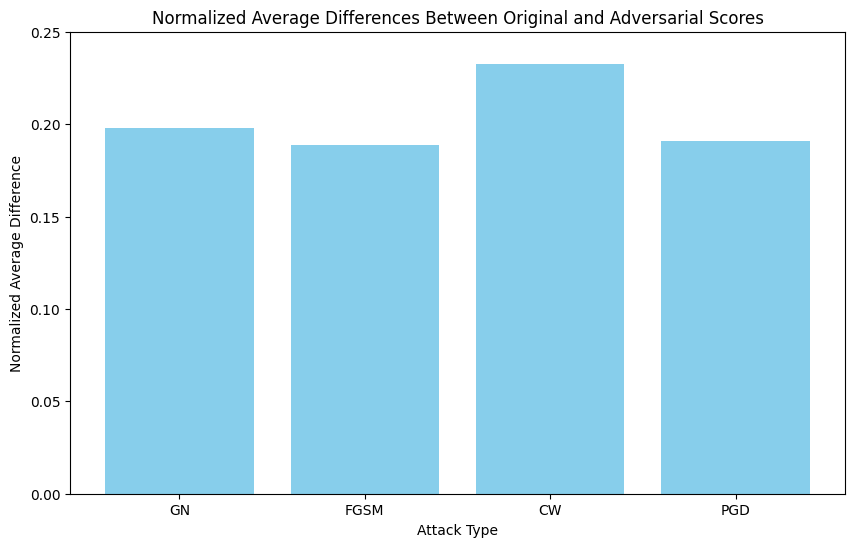

In [250]:
plot_values = {key: value[0][0][0].item() for key, value in average_differences.items()}

# Data for plotting
attacks = list(plot_values.keys())
values = list(plot_values.values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(attacks, values, color='skyblue')
plt.xlabel('Attack Type')
plt.ylabel('Normalized Average Difference')
plt.title('Normalized Average Differences Between Original and Adversarial Scores')
plt.ylim([0, 0.25])  # Set y-axis limits to better visualize the differences
plt.show()

From this graph, we see that the adversarial attacks, as expected, has a significant impact on the output result of the HPSV model. In particular, the Carlini-Wagner attack was most effective.

### Analyzing the Transferability of attacks

In [ ]:
def evaluate_original_images(images_tensor, prompt, hps_version):
    """
    Unnormalizes, converts, and evaluates the original images.
    
    Args:
        imagesz_tensor (Tensor): Original images tensor.
        prompt (str): Text prompt for scoring.
        hps_version (str): Version of hpsv2 to use for scoring.
        
    Returns:
        original_scores (list): List of scores for the original images.
        original_pil_images (list): List of original images converted to PIL format.
    """
    # Unnormalize original images
    original_images_unnorm = [unnormalize(img) for img in images_tensor]
    original_pil_images = [tensor_to_pil(img) for img in original_images_unnorm]
    
    # Evaluate original images
    original_scores = []
    for idx, img in enumerate(original_pil_images):
        score = hpsv2.score(img, prompt, hps_version=hps_version)
        original_scores.append(score)
        print(f"Original Image {idx} Score: {score}")
    
    return original_scores, original_pil_images

def process_and_evaluate_adversarial_images(adv_images, attack_name, prompt, original_scores=None, hps_version):
    """
    Processes and evaluates adversarial images.
    
    Args:
        adv_images (Tensor): Adversarial images tensor.
        attack_name (str): Name of the adversarial attack.
        prompt (str): Text prompt for scoring.
        hps_version (str): Version of hpsv2 to use for scoring.
        original_scores (list): Precomputed original scores for comparison.
        
    Returns:
        adv_scores (list): List of scores for the adversarial images.
        adv_pil_images (list): List of adversarial images converted to PIL format.
    """
    # Unnormalize adversarial images
    adv_images_unnorm = [unnormalize(img) for img in adv_images]
    adv_pil_images = [tensor_to_pil(img) for img in adv_images_unnorm]
    
    # Evaluate adversarial images
    adv_scores = []
    for idx, img in enumerate(adv_pil_images):
        score = hpsv2.score(img, prompt, hps_version=hps_version)
        adv_scores.append(score)
        print(f"{attack_name} Adversarial Image {idx} Score: {score}")
    
    # # Compare the scores if original_scores are provided
    # if original_scores is not None:
    #     for idx, (orig_score, adv_score) in enumerate(zip(original_scores, adv_scores)):
    #         score_diff = adv_score - orig_score
    #         print(f"{attack_name} Image {idx}: Original Score = {orig_score}, Adversarial Score = {adv_score}, Difference = {score_diff}")
    
    return adv_scores, adv_pil_images



In [ ]:
def evaluate_all_images(images_tensor, prompt, adv_images_dict,hps_version):
    """
    Evaluates original and adversarial images.

    Args:
        images_tensor (Tensor): Original images tensor.
        prompt (str): Text prompt for scoring.
       
        adv_images_dict (dict): Dictionary with attack names as keys and adversarial images as values.

    Returns:
        scores_dict (dict): Dictionary containing scores for original and adversarial images.
        pil_images_dict (dict): Dictionary containing PIL images for original and adversarial images.
    """
    # Evaluate original images
    original_scores, original_pil_images = evaluate_original_images(
        images_tensor, prompt, hps_version
    )
    
    scores_dict = {'original': original_scores}
    pil_images_dict = {'original': original_pil_images}

    # Process and evaluate adversarial images
    for attack_name, adv_images in adv_images_dict.items():
        adv_scores, adv_pil_images = process_and_evaluate_adversarial_images(
            adv_images, attack_name, prompt, original_scores, hps_version
        )
        scores_dict[attack_name] = adv_scores
        pil_images_dict[attack_name] = adv_pil_images

    return scores_dict, pil_images_dict


In [ ]:
all_scores = {
    'original': [],
    'GN': [],
    'FGSM': [],
    'CW': [],
    'PGD': []
}

In [ ]:
# attack = torchattacks.FGSM(model, eps=8/255)
for i in range(100):
    row = dataset['train'][i]
    images = [preprocess(img).unsqueeze(0).to(device) for img in row['image']]
    images_tensor = torch.cat([img.unsqueeze(0) for img in images], dim=0).to(device)
    images_tensor = images_tensor.squeeze(1)
    text_prompt = row['prompt']
    text_input = clip.tokenize([text_prompt]).to(device)
    labels = row['human_preference']
    labels_tensor = torch.tensor(labels).to(device)-1
    # print("Images shape:", images_tensor.shape)  # Should be [batch_size, 3, 224, 224]
    # print("Texts shape:", text_input.shape)    # Should be [batch_size, token_length]
    hps_version="v2.1"
    gn_adv_images = GN_attack(images_tensor, labels_tensor)
    fgsm_adv_images = fgsm_clip_attack(model, images_tensor, text_input, labels_tensor, 8/255, device)

    cw_adv_images = cw_clip_attack(model, images_tensor, text_input, labels_tensor, 10, device)
    pgd_adv_images = PGD_clip_attack(model, images_tensor, text_input, labels_tensor, eps=8/255, alpha=2/255, steps=40, device=device)

    # original_scores, original_pil_images = evaluate_original_images(
    #     images_tensor, text_prompt
    # )
    
    adv_images_dict = {
    'GN': gn_adv_images,
    'FGSM': fgsm_adv_images,
    'CW': cw_adv_images,
    'PGD': pgd_adv_images
    }

    # Call the merged evaluation method
    scores_dict, pil_images_dict = evaluate_all_images(
        images_tensor, text_prompt, adv_images_dict
    )
    for key in all_scores:
        all_scores[key].extend(scores_dict[key])


Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.26436514)]
Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.26436514)]
GN Adversarial Image 0 Score: [np.float32(0.15969518)]
GN Adversarial Image 1 Score: [np.float32(0.16902967)]
FGSM Adversarial Image 0 Score: [np.float32(0.15726678)]
FGSM Adversarial Image 1 Score: [np.float32(0.16044092)]
CW Adversarial Image 0 Score: [np.float32(0.15437013)]
CW Adversarial Image 1 Score: [np.float32(0.1569214)]
PGD Adversarial Image 0 Score: [np.float32(0.15453543)]
PGD Adversarial Image 1 Score: [np.float32(0.1597909)]
Original Image 0 Score: [np.float32(0.26436514)]
Original Image 1 Score: [np.float32(0.2588524)]
Original Image 0 Score: [np.float32(0.26436514)]
Original Image 1 Score: [np.float32(0.2588524)]
GN Adversarial Image 0 Score: [np.float32(0.16948634)]
GN Adversarial Image 1 Score: [np.float32(0.15619625)]
FGSM Adversarial Image 0 Score: [np.float32(0.16044092)]

In [254]:
# Iterate over each attack in the scores_dict
for attack_name in all_scores:
    if attack_name != 'original':
        # Get adversarial scores for the attack
        adv_scores = scores_dict[attack_name]
        diffs = []
        # for row in (zip(adv_scores,original_scores)):
        #     diffs.append(row[1]-row[1])
        # Compute differences between adversarial and original scores
        diffs = [adv_score[0] - orig_score for adv_score, orig_score in zip(adv_scores, original_scores)]
        # Store the differences in the dictionary
        score_differences[attack_name] = diffs
        

TypeError: 'float' object is not subscriptable

In [253]:
average_differences = {}

# Check if original scores are populated
if all_scores['original']:
    for attack in ['GN', 'FGSM', 'CW', 'PGD']:
        if all_scores[attack]:
            # Calculate differences and their average, unpacking the single-element lists
            differences = [(orig[0] if isinstance(orig, list) else orig) - (adv[0] if isinstance(adv, list) else adv)
                           for orig, adv in zip(all_scores['original'], all_scores[attack])]
            average_differences[attack] = sum(differences) / len(differences)
        else:
            average_differences[attack] = None  # Handle case where no data is available for attack

    # Normalize the average differences
    min_diff = min(filter(None, average_differences.values()))  # Ignore None values
    max_diff = max(filter(None, average_differences.values()))  # Ignore None values
    for attack in average_differences:
        if average_differences[attack] is not None:
            average_differences[attack] = (average_differences[attack] - min_diff) / (max_diff - min_diff)

print("Normalized average differences:", average_differences)



TypeError: unsupported operand type(s) for -: 'tuple' and 'float'

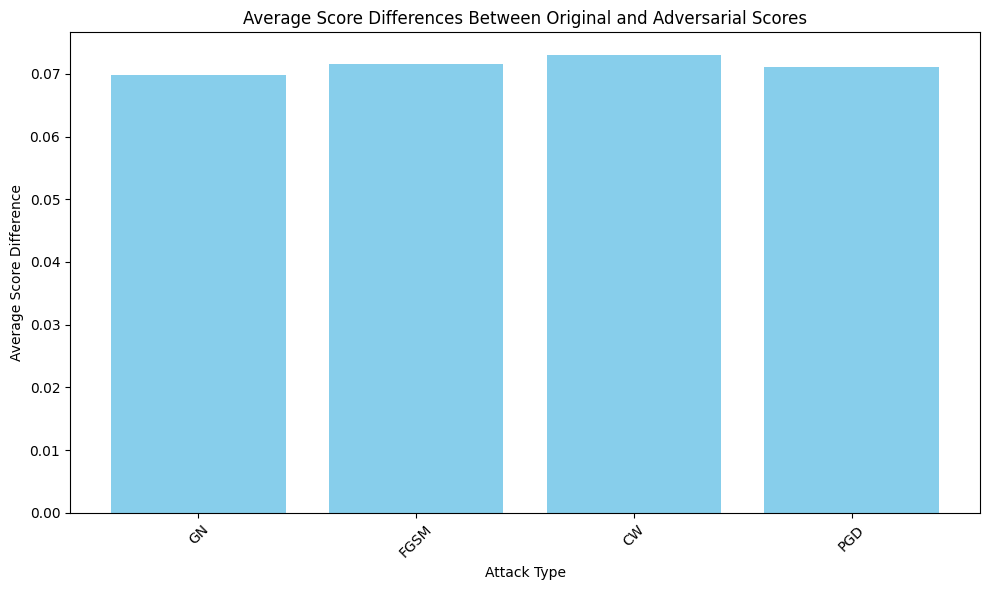

In [ ]:
import matplotlib.pyplot as plt

# Names of attacks and their corresponding average differences
attacks = list(average_differences.keys())
values = [avg_diff for avg_diff in average_differences.values() if avg_diff is not None]  # Ensure we only take non-None values
filtered_attacks = [attack for attack, avg_diff in average_differences.items() if avg_diff is not None]  # Filter out None for plotting

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(filtered_attacks, values, color='skyblue')
plt.xlabel('Attack Type')
plt.ylabel('Average Score Difference')
plt.title('Average Score Differences Between Original and Adversarial Scores')
plt.xticks(rotation=45)  # Rotate attack names for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()


From our data, it appears that the CW attack had the greatest effect on the average score differences between original and adversarial scores. However, noting the average score difference, it appears that the HPSV2 model was less susceptible to the adversarial images, indicating that the model itself is more resilient, but also that the attacks themselves are not particularly transferable in this instance. However, we can note that on average, the adversarial images are rated more poorly by the model.

In [252]:
all_scores = all_scores_orig#save scores

In [251]:
all_scores_hpsv = all_scores

In [255]:
import re

# Initialize the dictionary to store scores
all_scores = {
    'original': [],
    'GN': [],
    'FGSM': [],
    'CW': [],
    'PGD': []
}

# Helper function to extract float from the string
def extract_score(line):
    match = re.search(r'\(([^)]+)', line)
    return float(match.group(1)) if match else None

# Multiline string containing all the scores
data = """
Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.26436514)]
Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.26436514)]
GN Adversarial Image 0 Score: [np.float32(0.15969518)]
GN Adversarial Image 1 Score: [np.float32(0.16902967)]
FGSM Adversarial Image 0 Score: [np.float32(0.15726678)]
FGSM Adversarial Image 1 Score: [np.float32(0.16044092)]
CW Adversarial Image 0 Score: [np.float32(0.15437013)]
CW Adversarial Image 1 Score: [np.float32(0.1569214)]
PGD Adversarial Image 0 Score: [np.float32(0.15453543)]
PGD Adversarial Image 1 Score: [np.float32(0.1597909)]
Original Image 0 Score: [np.float32(0.26436514)]
Original Image 1 Score: [np.float32(0.2588524)]
Original Image 0 Score: [np.float32(0.26436514)]
Original Image 1 Score: [np.float32(0.2588524)]
GN Adversarial Image 0 Score: [np.float32(0.16948634)]
GN Adversarial Image 1 Score: [np.float32(0.15619625)]
FGSM Adversarial Image 0 Score: [np.float32(0.16044092)]
FGSM Adversarial Image 1 Score: [np.float32(0.15353009)]
CW Adversarial Image 0 Score: [np.float32(0.15700106)]
CW Adversarial Image 1 Score: [np.float32(0.15333119)]
PGD Adversarial Image 0 Score: [np.float32(0.15995353)]
PGD Adversarial Image 1 Score: [np.float32(0.15405405)]
Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.26163864)]
Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.26163864)]
GN Adversarial Image 0 Score: [np.float32(0.15975392)]
GN Adversarial Image 1 Score: [np.float32(0.19357748)]
FGSM Adversarial Image 0 Score: [np.float32(0.15726678)]
FGSM Adversarial Image 1 Score: [np.float32(0.19312727)]
CW Adversarial Image 0 Score: [np.float32(0.15437013)]
CW Adversarial Image 1 Score: [np.float32(0.1730696)]
PGD Adversarial Image 0 Score: [np.float32(0.15461351)]
PGD Adversarial Image 1 Score: [np.float32(0.19292916)]
Original Image 0 Score: [np.float32(0.2588524)]
Original Image 1 Score: [np.float32(0.26163864)]
Original Image 0 Score: [np.float32(0.2588524)]
Original Image 1 Score: [np.float32(0.26163864)]
GN Adversarial Image 0 Score: [np.float32(0.15466839)]
GN Adversarial Image 1 Score: [np.float32(0.19327623)]
FGSM Adversarial Image 0 Score: [np.float32(0.15353009)]
FGSM Adversarial Image 1 Score: [np.float32(0.19312727)]
CW Adversarial Image 0 Score: [np.float32(0.15278983)]
CW Adversarial Image 1 Score: [np.float32(0.1730696)]
PGD Adversarial Image 0 Score: [np.float32(0.15336666)]
PGD Adversarial Image 1 Score: [np.float32(0.19249097)]
Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.2588524)]
Original Image 0 Score: [np.float32(0.18202786)]
Original Image 1 Score: [np.float32(0.2588524)]
GN Adversarial Image 0 Score: [np.float32(0.15797752)]
GN Adversarial Image 1 Score: [np.float32(0.15389791)]
FGSM Adversarial Image 0 Score: [np.float32(0.15726678)]
FGSM Adversarial Image 1 Score: [np.float32(0.15353009)]
CW Adversarial Image 0 Score: [np.float32(0.15437013)]
CW Adversarial Image 1 Score: [np.float32(0.15333119)]
PGD Adversarial Image 0 Score: [np.float32(0.1542789)]
PGD Adversarial Image 1 Score: [np.float32(0.15316844)]
Original Image 0 Score: [np.float32(0.26436514)]
Original Image 1 Score: [np.float32(0.26163864)]
Original Image 0 Score: [np.float32(0.26436514)]
Original Image 1 Score: [np.float32(0.26163864)]
GN Adversarial Image 0 Score: [np.float32(0.16362083)]
GN Adversarial Image 1 Score: [np.float32(0.19153425)]
FGSM Adversarial Image 0 Score: [np.float32(0.16044092)]
FGSM Adversarial Image 1 Score: [np.float32(0.19312727)]
CW Adversarial Image 0 Score: [np.float32(0.15700106)]
CW Adversarial Image 1 Score: [np.float32(0.1730696)]
PGD Adversarial Image 0 Score: [np.float32(0.16001546)]
PGD Adversarial Image 1 Score: [np.float32(0.19207889)]
Original Image 0 Score: [np.float32(0.20486212)]
Original Image 1 Score: [np.float32(0.29626763)]
Original Image 0 Score: [np.float32(0.20486212)]
Original Image 1 Score: [np.float32(0.29626763)]
GN Adversarial Image 0 Score: [np.float32(0.1020261)]
GN Adversarial Image 1 Score: [np.float32(0.08795196)]
FGSM Adversarial Image 0 Score: [np.float32(0.1094589)]
FGSM Adversarial Image 1 Score: [np.float32(0.09040979)]
CW Adversarial Image 0 Score: [np.float32(0.1270023)]
CW Adversarial Image 1 Score: [np.float32(0.09855158)]
PGD Adversarial Image 0 Score: [np.float32(0.111798175)]
PGD Adversarial Image 1 Score: [np.float32(0.09069332)]
Original Image 0 Score: [np.float32(0.29626763)]
Original Image 1 Score: [np.float32(0.28297037)]
Original Image 0 Score: [np.float32(0.29626763)]
Original Image 1 Score: [np.float32(0.28297037)]
GN Adversarial Image 0 Score: [np.float32(0.09067793)]
GN Adversarial Image 1 Score: [np.float32(0.08788682)]
FGSM Adversarial Image 0 Score: [np.float32(0.09040979)]
FGSM Adversarial Image 1 Score: [np.float32(0.08440284)]
CW Adversarial Image 0 Score: [np.float32(0.098637536)]
CW Adversarial Image 1 Score: [np.float32(0.09317772)]
PGD Adversarial Image 0 Score: [np.float32(0.0899043)]
PGD Adversarial Image 1 Score: [np.float32(0.08386581)]
Original Image 0 Score: [np.float32(0.20486212)]
Original Image 1 Score: [np.float32(0.25416768)]
Original Image 0 Score: [np.float32(0.20486212)]
Original Image 1 Score: [np.float32(0.25416768)]
GN Adversarial Image 0 Score: [np.float32(0.10455787)]
GN Adversarial Image 1 Score: [np.float32(0.18800308)]
FGSM Adversarial Image 0 Score: [np.float32(0.1094589)]
FGSM Adversarial Image 1 Score: [np.float32(0.18440515)]
CW Adversarial Image 0 Score: [np.float32(0.1270023)]
CW Adversarial Image 1 Score: [np.float32(0.18137461)]
PGD Adversarial Image 0 Score: [np.float32(0.111311)]
PGD Adversarial Image 1 Score: [np.float32(0.18319112)]
Original Image 0 Score: [np.float32(0.28297037)]
Original Image 1 Score: [np.float32(0.25416768)]
Original Image 0 Score: [np.float32(0.28297037)]
Original Image 1 Score: [np.float32(0.25416768)]
GN Adversarial Image 0 Score: [np.float32(0.08741737)]
GN Adversarial Image 1 Score: [np.float32(0.18988074)]
FGSM Adversarial Image 0 Score: [np.float32(0.08440284)]
FGSM Adversarial Image 1 Score: [np.float32(0.18440515)]
CW Adversarial Image 0 Score: [np.float32(0.09455244)]
CW Adversarial Image 1 Score: [np.float32(0.18137461)]
PGD Adversarial Image 0 Score: [np.float32(0.08425788)]
PGD Adversarial Image 1 Score: [np.float32(0.18329522)]
Original Image 0 Score: [np.float32(0.20486212)]
Original Image 1 Score: [np.float32(0.28297037)]
Original Image 0 Score: [np.float32(0.20486212)]
Original Image 1 Score: [np.float32(0.28297037)]
GN Adversarial Image 0 Score: [np.float32(0.11028003)]
GN Adversarial Image 1 Score: [np.float32(0.08659873)]
FGSM Adversarial Image 0 Score: [np.float32(0.1094589)]
FGSM Adversarial Image 1 Score: [np.float32(0.08440284)]
CW Adversarial Image 0 Score: [np.float32(0.1270023)]
CW Adversarial Image 1 Score: [np.float32(0.09317772)]
PGD Adversarial Image 0 Score: [np.float32(0.11051281)]
PGD Adversarial Image 1 Score: [np.float32(0.0849581)]
Original Image 0 Score: [np.float32(0.29626763)]
Original Image 1 Score: [np.float32(0.25416768)]
Original Image 0 Score: [np.float32(0.29626763)]
Original Image 1 Score: [np.float32(0.25416768)]
GN Adversarial Image 0 Score: [np.float32(0.08795093)]
GN Adversarial Image 1 Score: [np.float32(0.19665153)]
FGSM Adversarial Image 0 Score: [np.float32(0.09040979)]
FGSM Adversarial Image 1 Score: [np.float32(0.18440515)]
CW Adversarial Image 0 Score: [np.float32(0.098637536)]
CW Adversarial Image 1 Score: [np.float32(0.18137461)]
PGD Adversarial Image 0 Score: [np.float32(0.09034021)]
PGD Adversarial Image 1 Score: [np.float32(0.18236439)]
Original Image 0 Score: [np.float32(0.11007668)]
Original Image 1 Score: [np.float32(0.29318538)]
Original Image 0 Score: [np.float32(0.11007668)]
Original Image 1 Score: [np.float32(0.29318538)]
GN Adversarial Image 0 Score: [np.float32(0.08799306)]
GN Adversarial Image 1 Score: [np.float32(0.24143189)]
FGSM Adversarial Image 0 Score: [np.float32(0.09330846)]
FGSM Adversarial Image 1 Score: [np.float32(0.24561568)]
CW Adversarial Image 0 Score: [np.float32(0.09517392)]
CW Adversarial Image 1 Score: [np.float32(0.24448684)]
PGD Adversarial Image 0 Score: [np.float32(0.0946397)]
PGD Adversarial Image 1 Score: [np.float32(0.24767822)]
Original Image 0 Score: [np.float32(0.29318538)]
Original Image 1 Score: [np.float32(0.28116047)]
Original Image 0 Score: [np.float32(0.29318538)]
Original Image 1 Score: [np.float32(0.28116047)]
GN Adversarial Image 0 Score: [np.float32(0.2410968)]
GN Adversarial Image 1 Score: [np.float32(0.22992054)]
FGSM Adversarial Image 0 Score: [np.float32(0.24561568)]
FGSM Adversarial Image 1 Score: [np.float32(0.22814153)]
CW Adversarial Image 0 Score: [np.float32(0.24416034)]
CW Adversarial Image 1 Score: [np.float32(0.2200368)]
PGD Adversarial Image 0 Score: [np.float32(0.24981634)]
PGD Adversarial Image 1 Score: [np.float32(0.22818814)]
Original Image 0 Score: [np.float32(0.11007668)]
Original Image 1 Score: [np.float32(0.2984478)]
Original Image 0 Score: [np.float32(0.11007668)]
Original Image 1 Score: [np.float32(0.2984478)]
GN Adversarial Image 0 Score: [np.float32(0.09027347)]
GN Adversarial Image 1 Score: [np.float32(0.20761122)]
FGSM Adversarial Image 0 Score: [np.float32(0.09330846)]
FGSM Adversarial Image 1 Score: [np.float32(0.19162843)]
CW Adversarial Image 0 Score: [np.float32(0.09517392)]
CW Adversarial Image 1 Score: [np.float32(0.20528522)]
PGD Adversarial Image 0 Score: [np.float32(0.09801782)]
PGD Adversarial Image 1 Score: [np.float32(0.19112861)]
Original Image 0 Score: [np.float32(0.28116047)]
Original Image 1 Score: [np.float32(0.2984478)]
Original Image 0 Score: [np.float32(0.28116047)]
Original Image 1 Score: [np.float32(0.2984478)]
GN Adversarial Image 0 Score: [np.float32(0.23196495)]
GN Adversarial Image 1 Score: [np.float32(0.20206447)]
FGSM Adversarial Image 0 Score: [np.float32(0.22814153)]
FGSM Adversarial Image 1 Score: [np.float32(0.19162843)]
CW Adversarial Image 0 Score: [np.float32(0.2208027)]
CW Adversarial Image 1 Score: [np.float32(0.20528522)]
PGD Adversarial Image 0 Score: [np.float32(0.22782789)]
PGD Adversarial Image 1 Score: [np.float32(0.19032782)]
Original Image 0 Score: [np.float32(0.11007668)]
Original Image 1 Score: [np.float32(0.28116047)]
Original Image 0 Score: [np.float32(0.11007668)]
Original Image 1 Score: [np.float32(0.28116047)]
GN Adversarial Image 0 Score: [np.float32(0.09140145)]
GN Adversarial Image 1 Score: [np.float32(0.22497141)]
FGSM Adversarial Image 0 Score: [np.float32(0.09330846)]
FGSM Adversarial Image 1 Score: [np.float32(0.22814153)]
CW Adversarial Image 0 Score: [np.float32(0.09517392)]
CW Adversarial Image 1 Score: [np.float32(0.2200368)]
PGD Adversarial Image 0 Score: [np.float32(0.096159026)]
PGD Adversarial Image 1 Score: [np.float32(0.22739172)]
Original Image 0 Score: [np.float32(0.29318538)]
Original Image 1 Score: [np.float32(0.2984478)]
Original Image 0 Score: [np.float32(0.29318538)]
Original Image 1 Score: [np.float32(0.2984478)]
GN Adversarial Image 0 Score: [np.float32(0.24017055)]
GN Adversarial Image 1 Score: [np.float32(0.20308846)]
FGSM Adversarial Image 0 Score: [np.float32(0.24561568)]
FGSM Adversarial Image 1 Score: [np.float32(0.19162843)]
CW Adversarial Image 0 Score: [np.float32(0.24416034)]
CW Adversarial Image 1 Score: [np.float32(0.20528522)]
PGD Adversarial Image 0 Score: [np.float32(0.24813566)]
PGD Adversarial Image 1 Score: [np.float32(0.19086383)]
Original Image 0 Score: [np.float32(0.25047666)]
Original Image 1 Score: [np.float32(0.28213817)]
Original Image 0 Score: [np.float32(0.25047666)]
Original Image 1 Score: [np.float32(0.28213817)]
GN Adversarial Image 0 Score: [np.float32(0.19096264)]
GN Adversarial Image 1 Score: [np.float32(0.19811976)]
FGSM Adversarial Image 0 Score: [np.float32(0.19319314)]
FGSM Adversarial Image 1 Score: [np.float32(0.18176077)]
CW Adversarial Image 0 Score: [np.float32(0.1829974)]
CW Adversarial Image 1 Score: [np.float32(0.18863767)]
PGD Adversarial Image 0 Score: [np.float32(0.20026083)]
PGD Adversarial Image 1 Score: [np.float32(0.19554727)]
Original Image 0 Score: [np.float32(0.28213817)]
Original Image 1 Score: [np.float32(0.2199695)]
Original Image 0 Score: [np.float32(0.28213817)]
Original Image 1 Score: [np.float32(0.2199695)]
GN Adversarial Image 0 Score: [np.float32(0.19781825)]
GN Adversarial Image 1 Score: [np.float32(0.18154883)]
FGSM Adversarial Image 0 Score: [np.float32(0.18176077)]
FGSM Adversarial Image 1 Score: [np.float32(0.17275351)]
CW Adversarial Image 0 Score: [np.float32(0.18807805)]
CW Adversarial Image 1 Score: [np.float32(0.17177922)]
PGD Adversarial Image 0 Score: [np.float32(0.19255668)]
PGD Adversarial Image 1 Score: [np.float32(0.17985776)]
Original Image 0 Score: [np.float32(0.25047666)]
Original Image 1 Score: [np.float32(0.24791709)]
Original Image 0 Score: [np.float32(0.25047666)]
Original Image 1 Score: [np.float32(0.24791709)]
GN Adversarial Image 0 Score: [np.float32(0.19475657)]
GN Adversarial Image 1 Score: [np.float32(0.19068462)]
FGSM Adversarial Image 0 Score: [np.float32(0.19319314)]
FGSM Adversarial Image 1 Score: [np.float32(0.18395644)]
CW Adversarial Image 0 Score: [np.float32(0.1829974)]
CW Adversarial Image 1 Score: [np.float32(0.18154234)]
PGD Adversarial Image 0 Score: [np.float32(0.2003068)]
PGD Adversarial Image 1 Score: [np.float32(0.1881573)]
Original Image 0 Score: [np.float32(0.2199695)]
Original Image 1 Score: [np.float32(0.24791709)]
Original Image 0 Score: [np.float32(0.2199695)]
Original Image 1 Score: [np.float32(0.24791709)]
GN Adversarial Image 0 Score: [np.float32(0.1785735)]
GN Adversarial Image 1 Score: [np.float32(0.19064744)]
FGSM Adversarial Image 0 Score: [np.float32(0.17275351)]
FGSM Adversarial Image 1 Score: [np.float32(0.18395644)]
CW Adversarial Image 0 Score: [np.float32(0.17077811)]
CW Adversarial Image 1 Score: [np.float32(0.18154234)]
PGD Adversarial Image 0 Score: [np.float32(0.18189603)]
PGD Adversarial Image 1 Score: [np.float32(0.18715222)]
Original Image 0 Score: [np.float32(0.25047666)]
Original Image 1 Score: [np.float32(0.2199695)]
Original Image 0 Score: [np.float32(0.25047666)]
Original Image 1 Score: [np.float32(0.2199695)]
GN Adversarial Image 0 Score: [np.float32(0.19574723)]
GN Adversarial Image 1 Score: [np.float32(0.1821)]
FGSM Adversarial Image 0 Score: [np.float32(0.19319314)]
FGSM Adversarial Image 1 Score: [np.float32(0.17275351)]
CW Adversarial Image 0 Score: [np.float32(0.1829974)]
CW Adversarial Image 1 Score: [np.float32(0.17177922)]
PGD Adversarial Image 0 Score: [np.float32(0.19990388)]
PGD Adversarial Image 1 Score: [np.float32(0.18160313)]
Original Image 0 Score: [np.float32(0.28213817)]
Original Image 1 Score: [np.float32(0.24791709)]
Original Image 0 Score: [np.float32(0.28213817)]
Original Image 1 Score: [np.float32(0.24791709)]
GN Adversarial Image 0 Score: [np.float32(0.19557962)]
GN Adversarial Image 1 Score: [np.float32(0.19134368)]
FGSM Adversarial Image 0 Score: [np.float32(0.18176077)]
FGSM Adversarial Image 1 Score: [np.float32(0.18395644)]
CW Adversarial Image 0 Score: [np.float32(0.18807805)]
CW Adversarial Image 1 Score: [np.float32(0.18154234)]
PGD Adversarial Image 0 Score: [np.float32(0.19166496)]
PGD Adversarial Image 1 Score: [np.float32(0.18783432)]
Original Image 0 Score: [np.float32(0.22436753)]
Original Image 1 Score: [np.float32(0.2870629)]
Original Image 0 Score: [np.float32(0.22436753)]
Original Image 1 Score: [np.float32(0.2870629)]
GN Adversarial Image 0 Score: [np.float32(0.15632801)]
GN Adversarial Image 1 Score: [np.float32(0.18117994)]
FGSM Adversarial Image 0 Score: [np.float32(0.15505649)]
FGSM Adversarial Image 1 Score: [np.float32(0.18194818)]
CW Adversarial Image 0 Score: [np.float32(0.1524609)]
CW Adversarial Image 1 Score: [np.float32(0.18172377)]
PGD Adversarial Image 0 Score: [np.float32(0.15143237)]
PGD Adversarial Image 1 Score: [np.float32(0.18123086)]
Original Image 0 Score: [np.float32(0.2870629)]
Original Image 1 Score: [np.float32(0.30700272)]
Original Image 0 Score: [np.float32(0.2870629)]
Original Image 1 Score: [np.float32(0.30700272)]
GN Adversarial Image 0 Score: [np.float32(0.17967848)]
GN Adversarial Image 1 Score: [np.float32(0.239933)]
FGSM Adversarial Image 0 Score: [np.float32(0.18194818)]
FGSM Adversarial Image 1 Score: [np.float32(0.23753123)]
CW Adversarial Image 0 Score: [np.float32(0.18200931)]
CW Adversarial Image 1 Score: [np.float32(0.23378664)]
PGD Adversarial Image 0 Score: [np.float32(0.18093854)]
PGD Adversarial Image 1 Score: [np.float32(0.23521405)]
Original Image 0 Score: [np.float32(0.22436753)]
Original Image 1 Score: [np.float32(0.23351315)]
Original Image 0 Score: [np.float32(0.22436753)]
Original Image 1 Score: [np.float32(0.23351315)]
GN Adversarial Image 0 Score: [np.float32(0.1519101)]
GN Adversarial Image 1 Score: [np.float32(0.16411164)]
FGSM Adversarial Image 0 Score: [np.float32(0.15505649)]
FGSM Adversarial Image 1 Score: [np.float32(0.16106342)]
CW Adversarial Image 0 Score: [np.float32(0.1524609)]
CW Adversarial Image 1 Score: [np.float32(0.15132438)]
PGD Adversarial Image 0 Score: [np.float32(0.15111354)]
PGD Adversarial Image 1 Score: [np.float32(0.15906103)]
Original Image 0 Score: [np.float32(0.30700272)]
Original Image 1 Score: [np.float32(0.23351315)]
Original Image 0 Score: [np.float32(0.30700272)]
Original Image 1 Score: [np.float32(0.23351315)]
GN Adversarial Image 0 Score: [np.float32(0.24058622)]
GN Adversarial Image 1 Score: [np.float32(0.16144592)]
FGSM Adversarial Image 0 Score: [np.float32(0.23753123)]
FGSM Adversarial Image 1 Score: [np.float32(0.16106342)]
CW Adversarial Image 0 Score: [np.float32(0.23413095)]
CW Adversarial Image 1 Score: [np.float32(0.15132438)]
PGD Adversarial Image 0 Score: [np.float32(0.23439416)]
PGD Adversarial Image 1 Score: [np.float32(0.16125242)]
Original Image 0 Score: [np.float32(0.22436753)]
Original Image 1 Score: [np.float32(0.30700272)]
Original Image 0 Score: [np.float32(0.22436753)]
Original Image 1 Score: [np.float32(0.30700272)]
GN Adversarial Image 0 Score: [np.float32(0.15527728)]
GN Adversarial Image 1 Score: [np.float32(0.2408185)]
FGSM Adversarial Image 0 Score: [np.float32(0.15505649)]
FGSM Adversarial Image 1 Score: [np.float32(0.23753123)]
CW Adversarial Image 0 Score: [np.float32(0.1524609)]
CW Adversarial Image 1 Score: [np.float32(0.23378664)]
PGD Adversarial Image 0 Score: [np.float32(0.15157485)]
PGD Adversarial Image 1 Score: [np.float32(0.23555279)]
Original Image 0 Score: [np.float32(0.2870629)]
Original Image 1 Score: [np.float32(0.23351315)]
Original Image 0 Score: [np.float32(0.2870629)]
Original Image 1 Score: [np.float32(0.23351315)]
GN Adversarial Image 0 Score: [np.float32(0.17963615)]
GN Adversarial Image 1 Score: [np.float32(0.16251664)]
FGSM Adversarial Image 0 Score: [np.float32(0.18194818)]
FGSM Adversarial Image 1 Score: [np.float32(0.16106342)]
CW Adversarial Image 0 Score: [np.float32(0.18200931)]
CW Adversarial Image 1 Score: [np.float32(0.15132438)]
PGD Adversarial Image 0 Score: [np.float32(0.18059018)]
PGD Adversarial Image 1 Score: [np.float32(0.16173741)]
Original Image 0 Score: [np.float32(0.18637468)]
Original Image 1 Score: [np.float32(0.26335588)]
Original Image 0 Score: [np.float32(0.18637468)]
Original Image 1 Score: [np.float32(0.26335588)]
GN Adversarial Image 0 Score: [np.float32(0.16350761)]
GN Adversarial Image 1 Score: [np.float32(0.20393232)]
FGSM Adversarial Image 0 Score: [np.float32(0.16008237)]
FGSM Adversarial Image 1 Score: [np.float32(0.19805944)]
CW Adversarial Image 0 Score: [np.float32(0.16460605)]
CW Adversarial Image 1 Score: [np.float32(0.1766504)]
PGD Adversarial Image 0 Score: [np.float32(0.15727521)]
PGD Adversarial Image 1 Score: [np.float32(0.20058453)]
Original Image 0 Score: [np.float32(0.26335588)]
Original Image 1 Score: [np.float32(0.29469937)]
Original Image 0 Score: [np.float32(0.26335588)]
Original Image 1 Score: [np.float32(0.29469937)]
GN Adversarial Image 0 Score: [np.float32(0.19555727)]
GN Adversarial Image 1 Score: [np.float32(0.20505169)]
FGSM Adversarial Image 0 Score: [np.float32(0.19805944)]
FGSM Adversarial Image 1 Score: [np.float32(0.19976947)]
CW Adversarial Image 0 Score: [np.float32(0.17689072)]
CW Adversarial Image 1 Score: [np.float32(0.18885311)]
PGD Adversarial Image 0 Score: [np.float32(0.20074706)]
PGD Adversarial Image 1 Score: [np.float32(0.19560441)]
Original Image 0 Score: [np.float32(0.18637468)]
Original Image 1 Score: [np.float32(0.24016209)]
Original Image 0 Score: [np.float32(0.18637468)]
Original Image 1 Score: [np.float32(0.24016209)]
GN Adversarial Image 0 Score: [np.float32(0.16460186)]
GN Adversarial Image 1 Score: [np.float32(0.15153879)]
FGSM Adversarial Image 0 Score: [np.float32(0.16008237)]
FGSM Adversarial Image 1 Score: [np.float32(0.14887051)]
CW Adversarial Image 0 Score: [np.float32(0.16460605)]
CW Adversarial Image 1 Score: [np.float32(0.15445523)]
PGD Adversarial Image 0 Score: [np.float32(0.15777835)]
PGD Adversarial Image 1 Score: [np.float32(0.14976713)]
Original Image 0 Score: [np.float32(0.29469937)]
Original Image 1 Score: [np.float32(0.24016209)]
Original Image 0 Score: [np.float32(0.29469937)]
Original Image 1 Score: [np.float32(0.24016209)]
GN Adversarial Image 0 Score: [np.float32(0.20295036)]
GN Adversarial Image 1 Score: [np.float32(0.15113078)]
FGSM Adversarial Image 0 Score: [np.float32(0.19976947)]
FGSM Adversarial Image 1 Score: [np.float32(0.14887051)]
CW Adversarial Image 0 Score: [np.float32(0.18808663)]
CW Adversarial Image 1 Score: [np.float32(0.15445523)]
PGD Adversarial Image 0 Score: [np.float32(0.19762713)]
PGD Adversarial Image 1 Score: [np.float32(0.14855693)]
Original Image 0 Score: [np.float32(0.18637468)]
Original Image 1 Score: [np.float32(0.29469937)]
Original Image 0 Score: [np.float32(0.18637468)]
Original Image 1 Score: [np.float32(0.29469937)]
GN Adversarial Image 0 Score: [np.float32(0.16690683)]
GN Adversarial Image 1 Score: [np.float32(0.20046188)]
FGSM Adversarial Image 0 Score: [np.float32(0.16008237)]
FGSM Adversarial Image 1 Score: [np.float32(0.19976947)]
CW Adversarial Image 0 Score: [np.float32(0.16460605)]
CW Adversarial Image 1 Score: [np.float32(0.18885311)]
PGD Adversarial Image 0 Score: [np.float32(0.15795906)]
PGD Adversarial Image 1 Score: [np.float32(0.19559503)]
Original Image 0 Score: [np.float32(0.26335588)]
Original Image 1 Score: [np.float32(0.24016209)]
Original Image 0 Score: [np.float32(0.26335588)]
Original Image 1 Score: [np.float32(0.24016209)]
GN Adversarial Image 0 Score: [np.float32(0.20344022)]
GN Adversarial Image 1 Score: [np.float32(0.15586519)]
FGSM Adversarial Image 0 Score: [np.float32(0.19805944)]
FGSM Adversarial Image 1 Score: [np.float32(0.14887051)]
CW Adversarial Image 0 Score: [np.float32(0.17689072)]
CW Adversarial Image 1 Score: [np.float32(0.15445523)]
PGD Adversarial Image 0 Score: [np.float32(0.20091061)]
PGD Adversarial Image 1 Score: [np.float32(0.1486235)]
Original Image 0 Score: [np.float32(0.19022246)]
Original Image 1 Score: [np.float32(0.19189222)]
Original Image 0 Score: [np.float32(0.19022246)]
Original Image 1 Score: [np.float32(0.19189222)]
GN Adversarial Image 0 Score: [np.float32(0.15841815)]
GN Adversarial Image 1 Score: [np.float32(0.17348632)]
FGSM Adversarial Image 0 Score: [np.float32(0.1601542)]
FGSM Adversarial Image 1 Score: [np.float32(0.18315306)]
CW Adversarial Image 0 Score: [np.float32(0.1700778)]
CW Adversarial Image 1 Score: [np.float32(0.17902033)]
PGD Adversarial Image 0 Score: [np.float32(0.16269466)]
PGD Adversarial Image 1 Score: [np.float32(0.18233112)]
Original Image 0 Score: [np.float32(0.19189222)]
Original Image 1 Score: [np.float32(0.22502667)]
Original Image 0 Score: [np.float32(0.19189222)]
Original Image 1 Score: [np.float32(0.22502667)]
GN Adversarial Image 0 Score: [np.float32(0.17036693)]
GN Adversarial Image 1 Score: [np.float32(0.17525186)]
FGSM Adversarial Image 0 Score: [np.float32(0.18315306)]
FGSM Adversarial Image 1 Score: [np.float32(0.16286135)]
CW Adversarial Image 0 Score: [np.float32(0.17759843)]
CW Adversarial Image 1 Score: [np.float32(0.17531231)]
PGD Adversarial Image 0 Score: [np.float32(0.18234892)]
PGD Adversarial Image 1 Score: [np.float32(0.16555168)]
Original Image 0 Score: [np.float32(0.19022246)]
Original Image 1 Score: [np.float32(0.19322975)]
Original Image 0 Score: [np.float32(0.19022246)]
Original Image 1 Score: [np.float32(0.19322975)]
GN Adversarial Image 0 Score: [np.float32(0.15712786)]
GN Adversarial Image 1 Score: [np.float32(0.1200135)]
FGSM Adversarial Image 0 Score: [np.float32(0.1601542)]
FGSM Adversarial Image 1 Score: [np.float32(0.11552039)]
CW Adversarial Image 0 Score: [np.float32(0.1700778)]
CW Adversarial Image 1 Score: [np.float32(0.12092358)]
PGD Adversarial Image 0 Score: [np.float32(0.16109245)]
PGD Adversarial Image 1 Score: [np.float32(0.11531545)]
Original Image 0 Score: [np.float32(0.22502667)]
Original Image 1 Score: [np.float32(0.19322975)]
Original Image 0 Score: [np.float32(0.22502667)]
Original Image 1 Score: [np.float32(0.19322975)]
GN Adversarial Image 0 Score: [np.float32(0.17429562)]
GN Adversarial Image 1 Score: [np.float32(0.121874556)]
FGSM Adversarial Image 0 Score: [np.float32(0.16286135)]
FGSM Adversarial Image 1 Score: [np.float32(0.11552039)]
CW Adversarial Image 0 Score: [np.float32(0.17489347)]
CW Adversarial Image 1 Score: [np.float32(0.12092358)]
PGD Adversarial Image 0 Score: [np.float32(0.16717246)]
PGD Adversarial Image 1 Score: [np.float32(0.1150914)]
Original Image 0 Score: [np.float32(0.19022246)]
Original Image 1 Score: [np.float32(0.22502667)]
Original Image 0 Score: [np.float32(0.19022246)]
Original Image 1 Score: [np.float32(0.22502667)]
GN Adversarial Image 0 Score: [np.float32(0.15734395)]
GN Adversarial Image 1 Score: [np.float32(0.17555726)]
FGSM Adversarial Image 0 Score: [np.float32(0.1601542)]
FGSM Adversarial Image 1 Score: [np.float32(0.16286135)]
CW Adversarial Image 0 Score: [np.float32(0.1700778)]
CW Adversarial Image 1 Score: [np.float32(0.17531231)]
PGD Adversarial Image 0 Score: [np.float32(0.16340831)]
PGD Adversarial Image 1 Score: [np.float32(0.1671575)]
Original Image 0 Score: [np.float32(0.19189222)]
Original Image 1 Score: [np.float32(0.19322975)]
Original Image 0 Score: [np.float32(0.19189222)]
Original Image 1 Score: [np.float32(0.19322975)]
GN Adversarial Image 0 Score: [np.float32(0.17001623)]
GN Adversarial Image 1 Score: [np.float32(0.11791617)]
FGSM Adversarial Image 0 Score: [np.float32(0.18315306)]
FGSM Adversarial Image 1 Score: [np.float32(0.11552039)]
CW Adversarial Image 0 Score: [np.float32(0.17759843)]
CW Adversarial Image 1 Score: [np.float32(0.12092358)]
PGD Adversarial Image 0 Score: [np.float32(0.18270528)]
PGD Adversarial Image 1 Score: [np.float32(0.1156454)]
Original Image 0 Score: [np.float32(0.14217447)]
Original Image 1 Score: [np.float32(0.3116304)]
Original Image 0 Score: [np.float32(0.14217447)]
Original Image 1 Score: [np.float32(0.3116304)]
GN Adversarial Image 0 Score: [np.float32(0.09625707)]
GN Adversarial Image 1 Score: [np.float32(0.24952672)]
FGSM Adversarial Image 0 Score: [np.float32(0.097106546)]
FGSM Adversarial Image 1 Score: [np.float32(0.24394077)]
CW Adversarial Image 0 Score: [np.float32(0.1004615)]
CW Adversarial Image 1 Score: [np.float32(0.25133967)]
PGD Adversarial Image 0 Score: [np.float32(0.09637349)]
PGD Adversarial Image 1 Score: [np.float32(0.24469882)]
Original Image 0 Score: [np.float32(0.3116304)]
Original Image 1 Score: [np.float32(0.2472377)]
Original Image 0 Score: [np.float32(0.3116304)]
Original Image 1 Score: [np.float32(0.2472377)]
GN Adversarial Image 0 Score: [np.float32(0.24855709)]
GN Adversarial Image 1 Score: [np.float32(0.16473791)]
FGSM Adversarial Image 0 Score: [np.float32(0.24394077)]
FGSM Adversarial Image 1 Score: [np.float32(0.16339833)]
CW Adversarial Image 0 Score: [np.float32(0.2523706)]
CW Adversarial Image 1 Score: [np.float32(0.16427574)]
PGD Adversarial Image 0 Score: [np.float32(0.24511784)]
PGD Adversarial Image 1 Score: [np.float32(0.16463856)]
Original Image 0 Score: [np.float32(0.14217447)]
Original Image 1 Score: [np.float32(0.27862346)]
Original Image 0 Score: [np.float32(0.14217447)]
Original Image 1 Score: [np.float32(0.27862346)]
GN Adversarial Image 0 Score: [np.float32(0.09583894)]
GN Adversarial Image 1 Score: [np.float32(0.2215848)]
FGSM Adversarial Image 0 Score: [np.float32(0.097106546)]
FGSM Adversarial Image 1 Score: [np.float32(0.21738845)]
CW Adversarial Image 0 Score: [np.float32(0.1004615)]
CW Adversarial Image 1 Score: [np.float32(0.22365858)]
PGD Adversarial Image 0 Score: [np.float32(0.096473284)]
PGD Adversarial Image 1 Score: [np.float32(0.22124425)]
Original Image 0 Score: [np.float32(0.2472377)]
Original Image 1 Score: [np.float32(0.27862346)]
Original Image 0 Score: [np.float32(0.2472377)]
Original Image 1 Score: [np.float32(0.27862346)]
GN Adversarial Image 0 Score: [np.float32(0.16687833)]
GN Adversarial Image 1 Score: [np.float32(0.22301894)]
FGSM Adversarial Image 0 Score: [np.float32(0.16339833)]
FGSM Adversarial Image 1 Score: [np.float32(0.21738845)]
CW Adversarial Image 0 Score: [np.float32(0.16428804)]
CW Adversarial Image 1 Score: [np.float32(0.22365858)]
PGD Adversarial Image 0 Score: [np.float32(0.16427287)]
PGD Adversarial Image 1 Score: [np.float32(0.22114575)]
Original Image 0 Score: [np.float32(0.14217447)]
Original Image 1 Score: [np.float32(0.2472377)]
Original Image 0 Score: [np.float32(0.14217447)]
Original Image 1 Score: [np.float32(0.2472377)]
GN Adversarial Image 0 Score: [np.float32(0.09535969)]
GN Adversarial Image 1 Score: [np.float32(0.16378203)]
FGSM Adversarial Image 0 Score: [np.float32(0.097106546)]
FGSM Adversarial Image 1 Score: [np.float32(0.16339833)]
CW Adversarial Image 0 Score: [np.float32(0.1004615)]
CW Adversarial Image 1 Score: [np.float32(0.16427574)]
PGD Adversarial Image 0 Score: [np.float32(0.0964235)]
PGD Adversarial Image 1 Score: [np.float32(0.16396517)]
Original Image 0 Score: [np.float32(0.3116304)]
Original Image 1 Score: [np.float32(0.27862346)]
Original Image 0 Score: [np.float32(0.3116304)]
Original Image 1 Score: [np.float32(0.27862346)]
GN Adversarial Image 0 Score: [np.float32(0.24719281)]
GN Adversarial Image 1 Score: [np.float32(0.22396615)]
FGSM Adversarial Image 0 Score: [np.float32(0.24394077)]
FGSM Adversarial Image 1 Score: [np.float32(0.21738845)]
CW Adversarial Image 0 Score: [np.float32(0.2523706)]
CW Adversarial Image 1 Score: [np.float32(0.22365858)]
PGD Adversarial Image 0 Score: [np.float32(0.24413496)]
PGD Adversarial Image 1 Score: [np.float32(0.22204232)]
Original Image 0 Score: [np.float32(0.23826529)]
Original Image 1 Score: [np.float32(0.24877307)]
Original Image 0 Score: [np.float32(0.23826529)]
Original Image 1 Score: [np.float32(0.24877307)]
GN Adversarial Image 0 Score: [np.float32(0.20986336)]
GN Adversarial Image 1 Score: [np.float32(0.17297637)]
FGSM Adversarial Image 0 Score: [np.float32(0.20755813)]
FGSM Adversarial Image 1 Score: [np.float32(0.17069589)]
CW Adversarial Image 0 Score: [np.float32(0.20074861)]
CW Adversarial Image 1 Score: [np.float32(0.16943227)]
PGD Adversarial Image 0 Score: [np.float32(0.20998354)]
PGD Adversarial Image 1 Score: [np.float32(0.17231184)]
Original Image 0 Score: [np.float32(0.24877307)]
Original Image 1 Score: [np.float32(0.24777867)]
Original Image 0 Score: [np.float32(0.24877307)]
Original Image 1 Score: [np.float32(0.24777867)]
GN Adversarial Image 0 Score: [np.float32(0.17456679)]
GN Adversarial Image 1 Score: [np.float32(0.1814625)]
FGSM Adversarial Image 0 Score: [np.float32(0.17069589)]
FGSM Adversarial Image 1 Score: [np.float32(0.19614615)]
CW Adversarial Image 0 Score: [np.float32(0.16933721)]
CW Adversarial Image 1 Score: [np.float32(0.18457586)]
PGD Adversarial Image 0 Score: [np.float32(0.17236686)]
PGD Adversarial Image 1 Score: [np.float32(0.19189976)]
Original Image 0 Score: [np.float32(0.23826529)]
Original Image 1 Score: [np.float32(0.22737685)]
Original Image 0 Score: [np.float32(0.23826529)]
Original Image 1 Score: [np.float32(0.22737685)]
GN Adversarial Image 0 Score: [np.float32(0.20878755)]
GN Adversarial Image 1 Score: [np.float32(0.17809643)]
FGSM Adversarial Image 0 Score: [np.float32(0.20755813)]
FGSM Adversarial Image 1 Score: [np.float32(0.17366742)]
CW Adversarial Image 0 Score: [np.float32(0.20074861)]
CW Adversarial Image 1 Score: [np.float32(0.17165413)]
PGD Adversarial Image 0 Score: [np.float32(0.21118607)]
PGD Adversarial Image 1 Score: [np.float32(0.17320581)]
Original Image 0 Score: [np.float32(0.24777867)]
Original Image 1 Score: [np.float32(0.22737685)]
Original Image 0 Score: [np.float32(0.24777867)]
Original Image 1 Score: [np.float32(0.22737685)]
GN Adversarial Image 0 Score: [np.float32(0.18244505)]
GN Adversarial Image 1 Score: [np.float32(0.18294382)]
FGSM Adversarial Image 0 Score: [np.float32(0.19614615)]
FGSM Adversarial Image 1 Score: [np.float32(0.17366742)]
CW Adversarial Image 0 Score: [np.float32(0.18429182)]
CW Adversarial Image 1 Score: [np.float32(0.17165413)]
PGD Adversarial Image 0 Score: [np.float32(0.19132267)]
PGD Adversarial Image 1 Score: [np.float32(0.17324373)]
Original Image 0 Score: [np.float32(0.23826529)]
Original Image 1 Score: [np.float32(0.24777867)]
Original Image 0 Score: [np.float32(0.23826529)]
Original Image 1 Score: [np.float32(0.24777867)]
GN Adversarial Image 0 Score: [np.float32(0.20749605)]
GN Adversarial Image 1 Score: [np.float32(0.1821473)]
FGSM Adversarial Image 0 Score: [np.float32(0.20755813)]
FGSM Adversarial Image 1 Score: [np.float32(0.19614615)]
CW Adversarial Image 0 Score: [np.float32(0.20074861)]
CW Adversarial Image 1 Score: [np.float32(0.18457586)]
PGD Adversarial Image 0 Score: [np.float32(0.21028692)]
PGD Adversarial Image 1 Score: [np.float32(0.19278036)]
Original Image 0 Score: [np.float32(0.24877307)]
Original Image 1 Score: [np.float32(0.22737685)]
Original Image 0 Score: [np.float32(0.24877307)]
Original Image 1 Score: [np.float32(0.22737685)]
GN Adversarial Image 0 Score: [np.float32(0.17650205)]
GN Adversarial Image 1 Score: [np.float32(0.17654541)]
FGSM Adversarial Image 0 Score: [np.float32(0.17069589)]
FGSM Adversarial Image 1 Score: [np.float32(0.17366742)]
CW Adversarial Image 0 Score: [np.float32(0.16933721)]
CW Adversarial Image 1 Score: [np.float32(0.17165413)]
PGD Adversarial Image 0 Score: [np.float32(0.17042392)]
PGD Adversarial Image 1 Score: [np.float32(0.17416602)]
Original Image 0 Score: [np.float32(0.20721081)]
Original Image 1 Score: [np.float32(0.26581985)]
Original Image 0 Score: [np.float32(0.20721081)]
Original Image 1 Score: [np.float32(0.26581985)]
GN Adversarial Image 0 Score: [np.float32(0.13769297)]
GN Adversarial Image 1 Score: [np.float32(0.23313996)]
FGSM Adversarial Image 0 Score: [np.float32(0.13929272)]
FGSM Adversarial Image 1 Score: [np.float32(0.23145881)]
CW Adversarial Image 0 Score: [np.float32(0.15058202)]
CW Adversarial Image 1 Score: [np.float32(0.23232263)]
PGD Adversarial Image 0 Score: [np.float32(0.13967198)]
PGD Adversarial Image 1 Score: [np.float32(0.22913264)]
Original Image 0 Score: [np.float32(0.26581985)]
Original Image 1 Score: [np.float32(0.22825009)]
Original Image 0 Score: [np.float32(0.26581985)]
Original Image 1 Score: [np.float32(0.22825009)]
GN Adversarial Image 0 Score: [np.float32(0.23313645)]
GN Adversarial Image 1 Score: [np.float32(0.1680786)]
FGSM Adversarial Image 0 Score: [np.float32(0.23145881)]
FGSM Adversarial Image 1 Score: [np.float32(0.17117755)]
CW Adversarial Image 0 Score: [np.float32(0.23232087)]
CW Adversarial Image 1 Score: [np.float32(0.1633384)]
PGD Adversarial Image 0 Score: [np.float32(0.22840783)]
PGD Adversarial Image 1 Score: [np.float32(0.17143285)]
Original Image 0 Score: [np.float32(0.20721081)]
Original Image 1 Score: [np.float32(0.2001346)]
Original Image 0 Score: [np.float32(0.20721081)]
Original Image 1 Score: [np.float32(0.2001346)]
GN Adversarial Image 0 Score: [np.float32(0.1397726)]
GN Adversarial Image 1 Score: [np.float32(0.18904407)]
FGSM Adversarial Image 0 Score: [np.float32(0.13929272)]
FGSM Adversarial Image 1 Score: [np.float32(0.1840687)]
CW Adversarial Image 0 Score: [np.float32(0.15058202)]
CW Adversarial Image 1 Score: [np.float32(0.18859845)]
PGD Adversarial Image 0 Score: [np.float32(0.13933702)]
PGD Adversarial Image 1 Score: [np.float32(0.18342887)]
Original Image 0 Score: [np.float32(0.22825009)]
Original Image 1 Score: [np.float32(0.2001346)]
Original Image 0 Score: [np.float32(0.22825009)]
Original Image 1 Score: [np.float32(0.2001346)]
GN Adversarial Image 0 Score: [np.float32(0.16693637)]
GN Adversarial Image 1 Score: [np.float32(0.18630962)]
FGSM Adversarial Image 0 Score: [np.float32(0.17117755)]
FGSM Adversarial Image 1 Score: [np.float32(0.1840687)]
CW Adversarial Image 0 Score: [np.float32(0.16322781)]
CW Adversarial Image 1 Score: [np.float32(0.18859845)]
PGD Adversarial Image 0 Score: [np.float32(0.17053233)]
PGD Adversarial Image 1 Score: [np.float32(0.18307966)]
Original Image 0 Score: [np.float32(0.20721081)]
Original Image 1 Score: [np.float32(0.22825009)]
Original Image 0 Score: [np.float32(0.20721081)]
Original Image 1 Score: [np.float32(0.22825009)]
GN Adversarial Image 0 Score: [np.float32(0.13946003)]
GN Adversarial Image 1 Score: [np.float32(0.16923518)]
FGSM Adversarial Image 0 Score: [np.float32(0.13929272)]
FGSM Adversarial Image 1 Score: [np.float32(0.17117755)]
CW Adversarial Image 0 Score: [np.float32(0.15058202)]
CW Adversarial Image 1 Score: [np.float32(0.1633384)]
PGD Adversarial Image 0 Score: [np.float32(0.1393953)]
PGD Adversarial Image 1 Score: [np.float32(0.16912057)]
Original Image 0 Score: [np.float32(0.26581985)]
Original Image 1 Score: [np.float32(0.2001346)]
Original Image 0 Score: [np.float32(0.26581985)]
Original Image 1 Score: [np.float32(0.2001346)]
GN Adversarial Image 0 Score: [np.float32(0.23235177)]
GN Adversarial Image 1 Score: [np.float32(0.1881442)]
FGSM Adversarial Image 0 Score: [np.float32(0.23145881)]
FGSM Adversarial Image 1 Score: [np.float32(0.1840687)]
CW Adversarial Image 0 Score: [np.float32(0.23232087)]
CW Adversarial Image 1 Score: [np.float32(0.18859845)]
PGD Adversarial Image 0 Score: [np.float32(0.22846335)]
PGD Adversarial Image 1 Score: [np.float32(0.18333685)]
Original Image 0 Score: [np.float32(0.24432291)]
Original Image 1 Score: [np.float32(0.25311482)]
Original Image 0 Score: [np.float32(0.24432291)]
Original Image 1 Score: [np.float32(0.25311482)]
GN Adversarial Image 0 Score: [np.float32(0.1677621)]
GN Adversarial Image 1 Score: [np.float32(0.18528633)]
FGSM Adversarial Image 0 Score: [np.float32(0.18514937)]
FGSM Adversarial Image 1 Score: [np.float32(0.18475308)]
CW Adversarial Image 0 Score: [np.float32(0.17202714)]
CW Adversarial Image 1 Score: [np.float32(0.17605358)]
PGD Adversarial Image 0 Score: [np.float32(0.1880234)]
PGD Adversarial Image 1 Score: [np.float32(0.18561435)]
Original Image 0 Score: [np.float32(0.25311482)]
Original Image 1 Score: [np.float32(0.27631682)]
Original Image 0 Score: [np.float32(0.25311482)]
Original Image 1 Score: [np.float32(0.27631682)]
GN Adversarial Image 0 Score: [np.float32(0.18255395)]
GN Adversarial Image 1 Score: [np.float32(0.19953272)]
FGSM Adversarial Image 0 Score: [np.float32(0.18475308)]
FGSM Adversarial Image 1 Score: [np.float32(0.1986869)]
CW Adversarial Image 0 Score: [np.float32(0.1750961)]
CW Adversarial Image 1 Score: [np.float32(0.19710627)]
PGD Adversarial Image 0 Score: [np.float32(0.18512283)]
PGD Adversarial Image 1 Score: [np.float32(0.19881135)]
Original Image 0 Score: [np.float32(0.24432291)]
Original Image 1 Score: [np.float32(0.23995309)]
Original Image 0 Score: [np.float32(0.24432291)]
Original Image 1 Score: [np.float32(0.23995309)]
GN Adversarial Image 0 Score: [np.float32(0.17089152)]
GN Adversarial Image 1 Score: [np.float32(0.13720247)]
FGSM Adversarial Image 0 Score: [np.float32(0.18514937)]
FGSM Adversarial Image 1 Score: [np.float32(0.12941135)]
CW Adversarial Image 0 Score: [np.float32(0.17202714)]
CW Adversarial Image 1 Score: [np.float32(0.13767675)]
PGD Adversarial Image 0 Score: [np.float32(0.18664362)]
PGD Adversarial Image 1 Score: [np.float32(0.13064438)]
Original Image 0 Score: [np.float32(0.27631682)]
Original Image 1 Score: [np.float32(0.23995309)]
Original Image 0 Score: [np.float32(0.27631682)]
Original Image 1 Score: [np.float32(0.23995309)]
GN Adversarial Image 0 Score: [np.float32(0.20280343)]
GN Adversarial Image 1 Score: [np.float32(0.13493757)]
FGSM Adversarial Image 0 Score: [np.float32(0.1986869)]
FGSM Adversarial Image 1 Score: [np.float32(0.12941135)]
CW Adversarial Image 0 Score: [np.float32(0.1973176)]
CW Adversarial Image 1 Score: [np.float32(0.13767675)]
PGD Adversarial Image 0 Score: [np.float32(0.19871323)]
PGD Adversarial Image 1 Score: [np.float32(0.12989935)]
Original Image 0 Score: [np.float32(0.24432291)]
Original Image 1 Score: [np.float32(0.27631682)]
Original Image 0 Score: [np.float32(0.24432291)]
Original Image 1 Score: [np.float32(0.27631682)]
GN Adversarial Image 0 Score: [np.float32(0.1689553)]
GN Adversarial Image 1 Score: [np.float32(0.2006711)]
FGSM Adversarial Image 0 Score: [np.float32(0.18514937)]
FGSM Adversarial Image 1 Score: [np.float32(0.1986869)]
CW Adversarial Image 0 Score: [np.float32(0.17202714)]
CW Adversarial Image 1 Score: [np.float32(0.19710627)]
PGD Adversarial Image 0 Score: [np.float32(0.18627036)]
PGD Adversarial Image 1 Score: [np.float32(0.19789118)]
Original Image 0 Score: [np.float32(0.25311482)]
Original Image 1 Score: [np.float32(0.23995309)]
Original Image 0 Score: [np.float32(0.25311482)]
Original Image 1 Score: [np.float32(0.23995309)]
GN Adversarial Image 0 Score: [np.float32(0.18693787)]
GN Adversarial Image 1 Score: [np.float32(0.13535081)]
FGSM Adversarial Image 0 Score: [np.float32(0.18475308)]
FGSM Adversarial Image 1 Score: [np.float32(0.12941135)]
CW Adversarial Image 0 Score: [np.float32(0.1750961)]
CW Adversarial Image 1 Score: [np.float32(0.13767675)]
PGD Adversarial Image 0 Score: [np.float32(0.1851837)]
PGD Adversarial Image 1 Score: [np.float32(0.13015853)]
Original Image 0 Score: [np.float32(0.16320416)]
Original Image 1 Score: [np.float32(0.22553721)]
Original Image 0 Score: [np.float32(0.16320416)]
Original Image 1 Score: [np.float32(0.22553721)]
GN Adversarial Image 0 Score: [np.float32(0.13344517)]
GN Adversarial Image 1 Score: [np.float32(0.14687058)]
FGSM Adversarial Image 0 Score: [np.float32(0.13362695)]
FGSM Adversarial Image 1 Score: [np.float32(0.14905576)]
CW Adversarial Image 0 Score: [np.float32(0.12775871)]
CW Adversarial Image 1 Score: [np.float32(0.14680102)]
PGD Adversarial Image 0 Score: [np.float32(0.12978311)]
PGD Adversarial Image 1 Score: [np.float32(0.14928037)]
Original Image 0 Score: [np.float32(0.22553721)]
Original Image 1 Score: [np.float32(0.24491328)]
Original Image 0 Score: [np.float32(0.22553721)]
Original Image 1 Score: [np.float32(0.24491328)]
GN Adversarial Image 0 Score: [np.float32(0.14825927)]
GN Adversarial Image 1 Score: [np.float32(0.16658702)]
FGSM Adversarial Image 0 Score: [np.float32(0.14905576)]
FGSM Adversarial Image 1 Score: [np.float32(0.170495)]
CW Adversarial Image 0 Score: [np.float32(0.14668262)]
CW Adversarial Image 1 Score: [np.float32(0.16901194)]
PGD Adversarial Image 0 Score: [np.float32(0.14929134)]
PGD Adversarial Image 1 Score: [np.float32(0.1679759)]
Original Image 0 Score: [np.float32(0.16320416)]
Original Image 1 Score: [np.float32(0.20520073)]
Original Image 0 Score: [np.float32(0.16320416)]
Original Image 1 Score: [np.float32(0.20520073)]
GN Adversarial Image 0 Score: [np.float32(0.13561231)]
GN Adversarial Image 1 Score: [np.float32(0.16619408)]
FGSM Adversarial Image 0 Score: [np.float32(0.13362695)]
FGSM Adversarial Image 1 Score: [np.float32(0.1646721)]
CW Adversarial Image 0 Score: [np.float32(0.12775871)]
CW Adversarial Image 1 Score: [np.float32(0.15583791)]
PGD Adversarial Image 0 Score: [np.float32(0.13244942)]
PGD Adversarial Image 1 Score: [np.float32(0.16541645)]
Original Image 0 Score: [np.float32(0.24491328)]
Original Image 1 Score: [np.float32(0.20520073)]
Original Image 0 Score: [np.float32(0.24491328)]
Original Image 1 Score: [np.float32(0.20520073)]
GN Adversarial Image 0 Score: [np.float32(0.1655962)]
GN Adversarial Image 1 Score: [np.float32(0.1667274)]
FGSM Adversarial Image 0 Score: [np.float32(0.170495)]
FGSM Adversarial Image 1 Score: [np.float32(0.1646721)]
CW Adversarial Image 0 Score: [np.float32(0.1690655)]
CW Adversarial Image 1 Score: [np.float32(0.15583791)]
PGD Adversarial Image 0 Score: [np.float32(0.16778512)]
PGD Adversarial Image 1 Score: [np.float32(0.16526029)]
Original Image 0 Score: [np.float32(0.16320416)]
Original Image 1 Score: [np.float32(0.24491328)]
Original Image 0 Score: [np.float32(0.16320416)]
Original Image 1 Score: [np.float32(0.24491328)]
GN Adversarial Image 0 Score: [np.float32(0.13201141)]
GN Adversarial Image 1 Score: [np.float32(0.16842939)]
FGSM Adversarial Image 0 Score: [np.float32(0.13362695)]
FGSM Adversarial Image 1 Score: [np.float32(0.170495)]
CW Adversarial Image 0 Score: [np.float32(0.12775871)]
CW Adversarial Image 1 Score: [np.float32(0.16901194)]
PGD Adversarial Image 0 Score: [np.float32(0.13275969)]
PGD Adversarial Image 1 Score: [np.float32(0.16698258)]
Original Image 0 Score: [np.float32(0.22553721)]
Original Image 1 Score: [np.float32(0.20520073)]
Original Image 0 Score: [np.float32(0.22553721)]
Original Image 1 Score: [np.float32(0.20520073)]
GN Adversarial Image 0 Score: [np.float32(0.14951624)]
GN Adversarial Image 1 Score: [np.float32(0.16617511)]
FGSM Adversarial Image 0 Score: [np.float32(0.14905576)]
FGSM Adversarial Image 1 Score: [np.float32(0.1646721)]
CW Adversarial Image 0 Score: [np.float32(0.14668262)]
CW Adversarial Image 1 Score: [np.float32(0.15583791)]
PGD Adversarial Image 0 Score: [np.float32(0.14974956)]
PGD Adversarial Image 1 Score: [np.float32(0.16508764)]
Original Image 0 Score: [np.float32(0.14323255)]
Original Image 1 Score: [np.float32(0.282469)]
Original Image 0 Score: [np.float32(0.14323255)]
Original Image 1 Score: [np.float32(0.282469)]
GN Adversarial Image 0 Score: [np.float32(0.11791146)]
GN Adversarial Image 1 Score: [np.float32(0.17599794)]
FGSM Adversarial Image 0 Score: [np.float32(0.113108344)]
FGSM Adversarial Image 1 Score: [np.float32(0.18407214)]
CW Adversarial Image 0 Score: [np.float32(0.100668356)]
CW Adversarial Image 1 Score: [np.float32(0.15486406)]
PGD Adversarial Image 0 Score: [np.float32(0.11445262)]
PGD Adversarial Image 1 Score: [np.float32(0.17880157)]
Original Image 0 Score: [np.float32(0.282469)]
Original Image 1 Score: [np.float32(0.31641352)]
Original Image 0 Score: [np.float32(0.282469)]
Original Image 1 Score: [np.float32(0.31641352)]
GN Adversarial Image 0 Score: [np.float32(0.17729636)]
GN Adversarial Image 1 Score: [np.float32(0.20517242)]
FGSM Adversarial Image 0 Score: [np.float32(0.18407214)]
FGSM Adversarial Image 1 Score: [np.float32(0.19958265)]
CW Adversarial Image 0 Score: [np.float32(0.15528545)]
CW Adversarial Image 1 Score: [np.float32(0.19105513)]
PGD Adversarial Image 0 Score: [np.float32(0.1809703)]
PGD Adversarial Image 1 Score: [np.float32(0.19700158)]
Original Image 0 Score: [np.float32(0.14323255)]
Original Image 1 Score: [np.float32(0.25216538)]
Original Image 0 Score: [np.float32(0.14323255)]
Original Image 1 Score: [np.float32(0.25216538)]
GN Adversarial Image 0 Score: [np.float32(0.11179343)]
GN Adversarial Image 1 Score: [np.float32(0.057929803)]
FGSM Adversarial Image 0 Score: [np.float32(0.113108344)]
FGSM Adversarial Image 1 Score: [np.float32(0.054837357)]
CW Adversarial Image 0 Score: [np.float32(0.100668356)]
CW Adversarial Image 1 Score: [np.float32(0.066245034)]
PGD Adversarial Image 0 Score: [np.float32(0.11551508)]
PGD Adversarial Image 1 Score: [np.float32(0.055109587)]
Original Image 0 Score: [np.float32(0.31641352)]
Original Image 1 Score: [np.float32(0.25216538)]
Original Image 0 Score: [np.float32(0.31641352)]
Original Image 1 Score: [np.float32(0.25216538)]
GN Adversarial Image 0 Score: [np.float32(0.19610599)]
GN Adversarial Image 1 Score: [np.float32(0.05551736)]
FGSM Adversarial Image 0 Score: [np.float32(0.19958265)]
FGSM Adversarial Image 1 Score: [np.float32(0.054837357)]
CW Adversarial Image 0 Score: [np.float32(0.19152942)]
CW Adversarial Image 1 Score: [np.float32(0.066245034)]
PGD Adversarial Image 0 Score: [np.float32(0.19655761)]
PGD Adversarial Image 1 Score: [np.float32(0.054744374)]
Original Image 0 Score: [np.float32(0.14323255)]
Original Image 1 Score: [np.float32(0.31641352)]
Original Image 0 Score: [np.float32(0.14323255)]
Original Image 1 Score: [np.float32(0.31641352)]
GN Adversarial Image 0 Score: [np.float32(0.1159304)]
GN Adversarial Image 1 Score: [np.float32(0.20818059)]
FGSM Adversarial Image 0 Score: [np.float32(0.113108344)]
FGSM Adversarial Image 1 Score: [np.float32(0.19958265)]
CW Adversarial Image 0 Score: [np.float32(0.100668356)]
CW Adversarial Image 1 Score: [np.float32(0.19105513)]
PGD Adversarial Image 0 Score: [np.float32(0.115581304)]
PGD Adversarial Image 1 Score: [np.float32(0.19585775)]
Original Image 0 Score: [np.float32(0.282469)]
Original Image 1 Score: [np.float32(0.25216538)]
Original Image 0 Score: [np.float32(0.282469)]
Original Image 1 Score: [np.float32(0.25216538)]
GN Adversarial Image 0 Score: [np.float32(0.1778729)]
GN Adversarial Image 1 Score: [np.float32(0.05400662)]
FGSM Adversarial Image 0 Score: [np.float32(0.18407214)]
FGSM Adversarial Image 1 Score: [np.float32(0.054837357)]
CW Adversarial Image 0 Score: [np.float32(0.15528545)]
CW Adversarial Image 1 Score: [np.float32(0.066245034)]
PGD Adversarial Image 0 Score: [np.float32(0.17933105)]
PGD Adversarial Image 1 Score: [np.float32(0.054951776)]
Original Image 0 Score: [np.float32(0.1429697)]
Original Image 1 Score: [np.float32(0.19057271)]
Original Image 0 Score: [np.float32(0.1429697)]
Original Image 1 Score: [np.float32(0.19057271)]
GN Adversarial Image 0 Score: [np.float32(0.14565018)]
GN Adversarial Image 1 Score: [np.float32(0.17577615)]
FGSM Adversarial Image 0 Score: [np.float32(0.1457346)]
FGSM Adversarial Image 1 Score: [np.float32(0.17091562)]
CW Adversarial Image 0 Score: [np.float32(0.14379878)]
CW Adversarial Image 1 Score: [np.float32(0.1698957)]
PGD Adversarial Image 0 Score: [np.float32(0.14569089)]
PGD Adversarial Image 1 Score: [np.float32(0.17150128)]
Original Image 0 Score: [np.float32(0.19057271)]
Original Image 1 Score: [np.float32(0.22345746)]
Original Image 0 Score: [np.float32(0.19057271)]
Original Image 1 Score: [np.float32(0.22345746)]
GN Adversarial Image 0 Score: [np.float32(0.17709702)]
GN Adversarial Image 1 Score: [np.float32(0.19927461)]
FGSM Adversarial Image 0 Score: [np.float32(0.17091562)]
FGSM Adversarial Image 1 Score: [np.float32(0.19341655)]
CW Adversarial Image 0 Score: [np.float32(0.17008606)]
CW Adversarial Image 1 Score: [np.float32(0.1933612)]
PGD Adversarial Image 0 Score: [np.float32(0.17056364)]
PGD Adversarial Image 1 Score: [np.float32(0.19392785)]
Original Image 0 Score: [np.float32(0.1429697)]
Original Image 1 Score: [np.float32(0.2174753)]
Original Image 0 Score: [np.float32(0.1429697)]
Original Image 1 Score: [np.float32(0.2174753)]
GN Adversarial Image 0 Score: [np.float32(0.14361542)]
GN Adversarial Image 1 Score: [np.float32(0.19434394)]
FGSM Adversarial Image 0 Score: [np.float32(0.1457346)]
FGSM Adversarial Image 1 Score: [np.float32(0.18842304)]
CW Adversarial Image 0 Score: [np.float32(0.14379878)]
CW Adversarial Image 1 Score: [np.float32(0.18070966)]
PGD Adversarial Image 0 Score: [np.float32(0.14553672)]
PGD Adversarial Image 1 Score: [np.float32(0.18789193)]
Original Image 0 Score: [np.float32(0.22345746)]
Original Image 1 Score: [np.float32(0.2174753)]
Original Image 0 Score: [np.float32(0.22345746)]
Original Image 1 Score: [np.float32(0.2174753)]
GN Adversarial Image 0 Score: [np.float32(0.1987779)]
GN Adversarial Image 1 Score: [np.float32(0.19491792)]
FGSM Adversarial Image 0 Score: [np.float32(0.19341655)]
FGSM Adversarial Image 1 Score: [np.float32(0.18842304)]
CW Adversarial Image 0 Score: [np.float32(0.1938674)]
CW Adversarial Image 1 Score: [np.float32(0.18070966)]
PGD Adversarial Image 0 Score: [np.float32(0.19393268)]
PGD Adversarial Image 1 Score: [np.float32(0.18901397)]
Original Image 0 Score: [np.float32(0.1429697)]
Original Image 1 Score: [np.float32(0.22345746)]
Original Image 0 Score: [np.float32(0.1429697)]
Original Image 1 Score: [np.float32(0.22345746)]
GN Adversarial Image 0 Score: [np.float32(0.14419238)]
GN Adversarial Image 1 Score: [np.float32(0.19813552)]
FGSM Adversarial Image 0 Score: [np.float32(0.1457346)]
FGSM Adversarial Image 1 Score: [np.float32(0.19341655)]
CW Adversarial Image 0 Score: [np.float32(0.14379878)]
CW Adversarial Image 1 Score: [np.float32(0.1933612)]
PGD Adversarial Image 0 Score: [np.float32(0.14563015)]
PGD Adversarial Image 1 Score: [np.float32(0.19332412)]
Original Image 0 Score: [np.float32(0.19057271)]
Original Image 1 Score: [np.float32(0.2174753)]
Original Image 0 Score: [np.float32(0.19057271)]
Original Image 1 Score: [np.float32(0.2174753)]
GN Adversarial Image 0 Score: [np.float32(0.17764726)]
GN Adversarial Image 1 Score: [np.float32(0.19467491)]
FGSM Adversarial Image 0 Score: [np.float32(0.17091562)]
FGSM Adversarial Image 1 Score: [np.float32(0.18842304)]
CW Adversarial Image 0 Score: [np.float32(0.17008606)]
CW Adversarial Image 1 Score: [np.float32(0.18070966)]
PGD Adversarial Image 0 Score: [np.float32(0.17180806)]
PGD Adversarial Image 1 Score: [np.float32(0.18832672)]
Original Image 0 Score: [np.float32(0.17610683)]
Original Image 1 Score: [np.float32(0.25096914)]
Original Image 0 Score: [np.float32(0.17610683)]
Original Image 1 Score: [np.float32(0.25096914)]
GN Adversarial Image 0 Score: [np.float32(0.12111152)]
GN Adversarial Image 1 Score: [np.float32(0.13442382)]
FGSM Adversarial Image 0 Score: [np.float32(0.11506776)]
FGSM Adversarial Image 1 Score: [np.float32(0.13210437)]
CW Adversarial Image 0 Score: [np.float32(0.124751635)]
CW Adversarial Image 1 Score: [np.float32(0.14032811)]
PGD Adversarial Image 0 Score: [np.float32(0.116541535)]
PGD Adversarial Image 1 Score: [np.float32(0.12968916)]
Original Image 0 Score: [np.float32(0.25096914)]
Original Image 1 Score: [np.float32(0.27914467)]
Original Image 0 Score: [np.float32(0.25096914)]
Original Image 1 Score: [np.float32(0.27914467)]
GN Adversarial Image 0 Score: [np.float32(0.1343417)]
GN Adversarial Image 1 Score: [np.float32(0.13260898)]
FGSM Adversarial Image 0 Score: [np.float32(0.13210437)]
FGSM Adversarial Image 1 Score: [np.float32(0.12252457)]
CW Adversarial Image 0 Score: [np.float32(0.13954198)]
CW Adversarial Image 1 Score: [np.float32(0.13311164)]
PGD Adversarial Image 0 Score: [np.float32(0.12993063)]
PGD Adversarial Image 1 Score: [np.float32(0.120780885)]
Original Image 0 Score: [np.float32(0.17610683)]
Original Image 1 Score: [np.float32(0.27539515)]
Original Image 0 Score: [np.float32(0.17610683)]
Original Image 1 Score: [np.float32(0.27539515)]
GN Adversarial Image 0 Score: [np.float32(0.12055142)]
GN Adversarial Image 1 Score: [np.float32(0.12269181)]
FGSM Adversarial Image 0 Score: [np.float32(0.11506776)]
FGSM Adversarial Image 1 Score: [np.float32(0.121144116)]
CW Adversarial Image 0 Score: [np.float32(0.124751635)]
CW Adversarial Image 1 Score: [np.float32(0.13167688)]
PGD Adversarial Image 0 Score: [np.float32(0.11797366)]
PGD Adversarial Image 1 Score: [np.float32(0.124266736)]
Original Image 0 Score: [np.float32(0.27914467)]
Original Image 1 Score: [np.float32(0.27539515)]
Original Image 0 Score: [np.float32(0.27914467)]
Original Image 1 Score: [np.float32(0.27539515)]
GN Adversarial Image 0 Score: [np.float32(0.1289139)]
GN Adversarial Image 1 Score: [np.float32(0.12708464)]
FGSM Adversarial Image 0 Score: [np.float32(0.12252457)]
FGSM Adversarial Image 1 Score: [np.float32(0.121144116)]
CW Adversarial Image 0 Score: [np.float32(0.13269733)]
CW Adversarial Image 1 Score: [np.float32(0.13167688)]
PGD Adversarial Image 0 Score: [np.float32(0.120149545)]
PGD Adversarial Image 1 Score: [np.float32(0.12330614)]
Original Image 0 Score: [np.float32(0.17610683)]
Original Image 1 Score: [np.float32(0.27914467)]
Original Image 0 Score: [np.float32(0.17610683)]
Original Image 1 Score: [np.float32(0.27914467)]
GN Adversarial Image 0 Score: [np.float32(0.11984436)]
GN Adversarial Image 1 Score: [np.float32(0.12654883)]
FGSM Adversarial Image 0 Score: [np.float32(0.11506776)]
FGSM Adversarial Image 1 Score: [np.float32(0.12252457)]
CW Adversarial Image 0 Score: [np.float32(0.124751635)]
CW Adversarial Image 1 Score: [np.float32(0.13311164)]
PGD Adversarial Image 0 Score: [np.float32(0.11703276)]
PGD Adversarial Image 1 Score: [np.float32(0.118996724)]
Original Image 0 Score: [np.float32(0.25096914)]
Original Image 1 Score: [np.float32(0.27539515)]
Original Image 0 Score: [np.float32(0.25096914)]
Original Image 1 Score: [np.float32(0.27539515)]
GN Adversarial Image 0 Score: [np.float32(0.13196363)]
GN Adversarial Image 1 Score: [np.float32(0.12317869)]
FGSM Adversarial Image 0 Score: [np.float32(0.13210437)]
FGSM Adversarial Image 1 Score: [np.float32(0.121144116)]
CW Adversarial Image 0 Score: [np.float32(0.13954198)]
CW Adversarial Image 1 Score: [np.float32(0.13167688)]
PGD Adversarial Image 0 Score: [np.float32(0.13040833)]
PGD Adversarial Image 1 Score: [np.float32(0.12373372)]
Original Image 0 Score: [np.float32(0.15177199)]
Original Image 1 Score: [np.float32(0.21145853)]
Original Image 0 Score: [np.float32(0.15177199)]
Original Image 1 Score: [np.float32(0.21145853)]
GN Adversarial Image 0 Score: [np.float32(0.110026255)]
GN Adversarial Image 1 Score: [np.float32(0.15863411)]
FGSM Adversarial Image 0 Score: [np.float32(0.10515045)]
FGSM Adversarial Image 1 Score: [np.float32(0.15141281)]
CW Adversarial Image 0 Score: [np.float32(0.10884473)]
CW Adversarial Image 1 Score: [np.float32(0.15048386)]
PGD Adversarial Image 0 Score: [np.float32(0.10852267)]
PGD Adversarial Image 1 Score: [np.float32(0.15133297)]
Original Image 0 Score: [np.float32(0.21145853)]
Original Image 1 Score: [np.float32(0.20827325)]
Original Image 0 Score: [np.float32(0.21145853)]
Original Image 1 Score: [np.float32(0.20827325)]
GN Adversarial Image 0 Score: [np.float32(0.15648901)]
GN Adversarial Image 1 Score: [np.float32(0.15963987)]
FGSM Adversarial Image 0 Score: [np.float32(0.15141281)]
FGSM Adversarial Image 1 Score: [np.float32(0.15496704)]
CW Adversarial Image 0 Score: [np.float32(0.15033996)]
CW Adversarial Image 1 Score: [np.float32(0.15098885)]
PGD Adversarial Image 0 Score: [np.float32(0.15163577)]
PGD Adversarial Image 1 Score: [np.float32(0.1554711)]
Original Image 0 Score: [np.float32(0.15177199)]
Original Image 1 Score: [np.float32(0.17817923)]
Original Image 0 Score: [np.float32(0.15177199)]
Original Image 1 Score: [np.float32(0.17817923)]
GN Adversarial Image 0 Score: [np.float32(0.10867123)]
GN Adversarial Image 1 Score: [np.float32(0.16134375)]
FGSM Adversarial Image 0 Score: [np.float32(0.10515045)]
FGSM Adversarial Image 1 Score: [np.float32(0.15863241)]
CW Adversarial Image 0 Score: [np.float32(0.10884473)]
CW Adversarial Image 1 Score: [np.float32(0.15983483)]
PGD Adversarial Image 0 Score: [np.float32(0.10924417)]
PGD Adversarial Image 1 Score: [np.float32(0.16209216)]
Original Image 0 Score: [np.float32(0.20827325)]
Original Image 1 Score: [np.float32(0.17817923)]
Original Image 0 Score: [np.float32(0.20827325)]
Original Image 1 Score: [np.float32(0.17817923)]
GN Adversarial Image 0 Score: [np.float32(0.15803571)]
GN Adversarial Image 1 Score: [np.float32(0.16001675)]
FGSM Adversarial Image 0 Score: [np.float32(0.15496704)]
FGSM Adversarial Image 1 Score: [np.float32(0.15863241)]
CW Adversarial Image 0 Score: [np.float32(0.15064178)]
CW Adversarial Image 1 Score: [np.float32(0.15983483)]
PGD Adversarial Image 0 Score: [np.float32(0.15559109)]
PGD Adversarial Image 1 Score: [np.float32(0.16187748)]
Original Image 0 Score: [np.float32(0.15177199)]
Original Image 1 Score: [np.float32(0.20827325)]
Original Image 0 Score: [np.float32(0.15177199)]
Original Image 1 Score: [np.float32(0.20827325)]
GN Adversarial Image 0 Score: [np.float32(0.109991655)]
GN Adversarial Image 1 Score: [np.float32(0.15928648)]
FGSM Adversarial Image 0 Score: [np.float32(0.10515045)]
FGSM Adversarial Image 1 Score: [np.float32(0.15496704)]
CW Adversarial Image 0 Score: [np.float32(0.10884473)]
CW Adversarial Image 1 Score: [np.float32(0.15098885)]
PGD Adversarial Image 0 Score: [np.float32(0.11053415)]
PGD Adversarial Image 1 Score: [np.float32(0.15552016)]
Original Image 0 Score: [np.float32(0.21145853)]
Original Image 1 Score: [np.float32(0.17817923)]
Original Image 0 Score: [np.float32(0.21145853)]
Original Image 1 Score: [np.float32(0.17817923)]
GN Adversarial Image 0 Score: [np.float32(0.15806298)]
GN Adversarial Image 1 Score: [np.float32(0.15851125)]
FGSM Adversarial Image 0 Score: [np.float32(0.15141281)]
FGSM Adversarial Image 1 Score: [np.float32(0.15863241)]
CW Adversarial Image 0 Score: [np.float32(0.15033996)]
CW Adversarial Image 1 Score: [np.float32(0.15983483)]
PGD Adversarial Image 0 Score: [np.float32(0.15329249)]
PGD Adversarial Image 1 Score: [np.float32(0.16151527)]
Original Image 0 Score: [np.float32(0.16991487)]
Original Image 1 Score: [np.float32(0.25954074)]
Original Image 0 Score: [np.float32(0.16991487)]
Original Image 1 Score: [np.float32(0.25954074)]
GN Adversarial Image 0 Score: [np.float32(0.11951716)]
GN Adversarial Image 1 Score: [np.float32(0.15892409)]
FGSM Adversarial Image 0 Score: [np.float32(0.12060059)]
FGSM Adversarial Image 1 Score: [np.float32(0.15024425)]
CW Adversarial Image 0 Score: [np.float32(0.096167296)]
CW Adversarial Image 1 Score: [np.float32(0.14753291)]
PGD Adversarial Image 0 Score: [np.float32(0.12137079)]
PGD Adversarial Image 1 Score: [np.float32(0.15558463)]
Original Image 0 Score: [np.float32(0.25954074)]
Original Image 1 Score: [np.float32(0.2730432)]
Original Image 0 Score: [np.float32(0.25954074)]
Original Image 1 Score: [np.float32(0.2730432)]
GN Adversarial Image 0 Score: [np.float32(0.15921366)]
GN Adversarial Image 1 Score: [np.float32(0.19045717)]
FGSM Adversarial Image 0 Score: [np.float32(0.15024425)]
FGSM Adversarial Image 1 Score: [np.float32(0.19136839)]
CW Adversarial Image 0 Score: [np.float32(0.14781293)]
CW Adversarial Image 1 Score: [np.float32(0.18130393)]
PGD Adversarial Image 0 Score: [np.float32(0.15449153)]
PGD Adversarial Image 1 Score: [np.float32(0.1917078)]
Original Image 0 Score: [np.float32(0.16991487)]
Original Image 1 Score: [np.float32(0.2226459)]
Original Image 0 Score: [np.float32(0.16991487)]
Original Image 1 Score: [np.float32(0.2226459)]
GN Adversarial Image 0 Score: [np.float32(0.11816087)]
GN Adversarial Image 1 Score: [np.float32(0.17045717)]
FGSM Adversarial Image 0 Score: [np.float32(0.12060059)]
FGSM Adversarial Image 1 Score: [np.float32(0.17458439)]
CW Adversarial Image 0 Score: [np.float32(0.096167296)]
CW Adversarial Image 1 Score: [np.float32(0.16831033)]
PGD Adversarial Image 0 Score: [np.float32(0.121383116)]
PGD Adversarial Image 1 Score: [np.float32(0.17622283)]
Original Image 0 Score: [np.float32(0.2730432)]
Original Image 1 Score: [np.float32(0.2226459)]
Original Image 0 Score: [np.float32(0.2730432)]
Original Image 1 Score: [np.float32(0.2226459)]
GN Adversarial Image 0 Score: [np.float32(0.19033888)]
GN Adversarial Image 1 Score: [np.float32(0.17050003)]
FGSM Adversarial Image 0 Score: [np.float32(0.19136839)]
FGSM Adversarial Image 1 Score: [np.float32(0.17458439)]
CW Adversarial Image 0 Score: [np.float32(0.18073969)]
CW Adversarial Image 1 Score: [np.float32(0.16831033)]
PGD Adversarial Image 0 Score: [np.float32(0.19109823)]
PGD Adversarial Image 1 Score: [np.float32(0.17552565)]

"""

# Keep track of original images to skip every other pair
original_counter = 0

# Parse the data
for line in data.split('\n'):
    if "Original" in line:
        if original_counter % 4 == 0 or original_counter % 4 == 1:  # Take only the first two of every four
            score = extract_score(line)
            if score is not None:
                all_scores['original'].append(score)
        original_counter += 1
    elif "GN" in line:
        score = extract_score(line)
        if score is not None:
            all_scores['GN'].append(score)
    elif "FGSM" in line:
        score = extract_score(line)
        if score is not None:
            all_scores['FGSM'].append(score)
    elif "CW" in line:
        score = extract_score(line)
        if score is not None:
            all_scores['CW'].append(score)
    elif "PGD" in line:
        score = extract_score(line)
        if score is not None:
            all_scores['PGD'].append(score)

# Print the all_scores dictionary to verify
for key, values in all_scores.items():
    print(f"{key}: {values[:10]} ...")  # Print the first 10 scores for brevity


{'original': [[np.float32(0.18202786)],
  [np.float32(0.26436514)],
  [np.float32(0.26436514)],
  [np.float32(0.2588524)],
  [np.float32(0.18202786)],
  [np.float32(0.26163864)],
  [np.float32(0.2588524)],
  [np.float32(0.26163864)],
  [np.float32(0.18202786)],
  [np.float32(0.2588524)],
  [np.float32(0.26436514)],
  [np.float32(0.26163864)],
  [np.float32(0.20486212)],
  [np.float32(0.29626763)],
  [np.float32(0.18202786)],
  [np.float32(0.26436514)],
  [np.float32(0.26436514)],
  [np.float32(0.2588524)],
  [np.float32(0.18202786)],
  [np.float32(0.26163864)],
  [np.float32(0.2588524)],
  [np.float32(0.26163864)],
  [np.float32(0.18202786)],
  [np.float32(0.2588524)],
  [np.float32(0.26436514)],
  [np.float32(0.26163864)],
  [np.float32(0.20486212)],
  [np.float32(0.29626763)],
  [np.float32(0.29626763)],
  [np.float32(0.28297037)],
  [np.float32(0.20486212)],
  [np.float32(0.25416768)],
  [np.float32(0.28297037)],
  [np.float32(0.25416768)],
  [np.float32(0.20486212)],
  [np.float32(